# 0. Imports

## 0.1. Importing Libraries

In [347]:
import math
import inflection

import pandas   as pd
import numpy    as np
import seaborn  as sns

from matplotlib            import pyplot as plt
from scipy                 import stats  as ss

from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1. Helper Functions

In [342]:
# Função auxiliar:

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams[ 'figure.figsize' ] = [20, 10]
    plt.rcParams[ 'font.size' ] = 20
    
    display( HTML( '<style>.container { width:95% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
# Funcão de correlacão de variáveis categóricas, utilizando do método estatístico de Cramer's V:
def cramer_v( x, y ):
    
    #Inicialmente, calcula-se a "confusion matrix"
    cm = pd.crosstab( x, y ).values
    
    #Calcula-se as variáveis do método
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    #Ao final, a funcão retorna a própria equacão de cramer's V
    return np.sqrt( ( chi2/n )/( min(  k-1, r-1 ) ) )


# Funcão de Cramer's V com correcão de viés:
def cramer_v_corr( x, y ):
    
    #Inicialmente, calcula-se a "confusion matrix"
    cm = pd.crosstab( x, y ).values
    
    
    #As variáveis de Cramer's V, sem a correcão, são dados como sendo
    n = cm.sum()
    r, k = cm.shape
    
    #Define-se o valor de chi2
    chi2 = ss.chi2_contingency(cm)[0]
    
    
    #O valor de chi2 corrigido é dado como sendo
    chi2_corr = max( 0, chi2 - ( (k - 1)*(r - 1) ) / (n - 1) )
    
    
    #Calcula-se as variáveis do método
    k_corr = k - (k - 1)**2 / (n - 1)
    r_corr = r - (r - 1)**2 / (n - 1)
    
    
    #Ao final, a funcão retorna a própria equacão de cramer's V
    return np.sqrt( (chi2_corr / n) / ( min( k_corr - 1, r_corr - 1 ) ) )

In [135]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [223]:
# Suppressing the scientific notation of the metrics

# pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 0.2. Loading the Data

In [227]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory = False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory = False )

#Merge of both dataframes:
df_raw = pd.merge( df_sales_raw, df_store_raw, on = 'Store', how = 'left' )

In [228]:
#Verifying the merging:

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
259889,167,6,2014-12-06,7128,756,1,0,0,0,a,a,140.00,4.00,2008.00,0,NaN,NaN,NaN


In [226]:
df1 = df_raw.copy()

# 1. (Passo 1) Descricao dos Dados

## 1.1. Renaming the columns 

In [229]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )  #funcao 'map' faz o mapeamento a partir da funcao 'snakecase' 
                                               #de todas as palavras da lista 'cols_old'.
    
#Reanming the columns:
df1.columns = cols_new

## 1.2. Data Dimensions 

In [230]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )

print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types 

In [232]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking the 'NA's  

In [233]:
df1.isna().sum()

#É possível observar que da coluna 'store' até a coluna 'assortment', não existem dados faltantes, ou 'NA's. 
#Entretanto, para as outras colunas, sim! Isso pode variar desde erros manuais na insercao dos dados até 
#características do negócio que definiram a presenca desses dados faltantes. É interessante entender o motivo
#pelo qual esses dados estão como 'NA'.

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Filling in the 'NA' Data

In [234]:
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [235]:
# competition_distance              2642

    #distance in meters to the nearest competitor store.
    
    ##1st Hypothesis: 
    ##2nd Hypothesis: 
    
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )
    

# competition_open_since_month    323348

    #gives the approximate month of the time the nearest competitor was opened.
    
    ##1st Hypothesis: Não existe competidor mais próximo, ou está longe demais, e por isso não existe 
                     #data de abertura para a competicao mais próxima.
    ##2nd Hypothesis: Realmente existe uma competicao próxima (Dentro do range do 'competition_distace'),
                     #porém não se sabe quando a loja abriu.
    
df1['competition_open_since_month'] = df1.apply( lambda x: 
                                                
                                        x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis = 1 )
    

# competition_open_since_year     323348

    #gives the approximate year of the time the nearest competitor was opened
    

    
df1['competition_open_since_year'] = df1.apply( lambda x: 
                                                
                                        x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                        else x['competition_open_since_year'], axis = 1 )


# promo2_since_week               508031

    #describes the calendar week when the store started participating in Promo2.
    ##If the data within 'promo2_since_week' = Na, it means that the store decided not to participate
    ##in the promotion ('promo2'). Hence, there's no info about this.
    

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
                                               
                                               if math.isnan( x['promo2_since_week'] ) 
                                               else x['promo2_since_week'], axis = 1 )

    

#promo2_since_year               508031

    #describes the year when the store started participating in Promo2
    
    
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
                                               
                                               if math.isnan( x['promo2_since_year'] ) 
                                               else x['promo2_since_year'], axis = 1 ) 


# promo_interval                  508031

    #describes the consecutive intervals Promo2 is started, naming the months the promotion is 
    #started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November 
    #of any given year for that store

    
month_map = { 1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9: 'Sept', 
              10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo?'] = df1[['promo_interval', 'month_map']].apply( lambda x: 
                                                             
                                                 0 if x['promo_interval'] == 0 else 
                                                 1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                 0, axis = 1 )





KeyboardInterrupt: 

In [147]:
df1.sample(10).T

,813781,502249,876204,987256,349267,343781,532025,276820,396522,792576
store,617,170,600,152,827,970,956,290,314,597
day_of_week,2,1,2,7,2,1,3,2,7,7
date,2013-07-02 00:00:00,2014-04-07 00:00:00,2013-05-07 00:00:00,2013-01-27 00:00:00,2014-09-02 00:00:00,2014-09-08 00:00:00,2014-03-12 00:00:00,2014-11-18 00:00:00,2014-07-13 00:00:00,2013-07-21 00:00:00
sales,6107,3958,5270,0,13974,3089,3098,6419,0,0
customers,555,512,523,0,1781,437,493,694,0,0
open,1,1,1,0,1,1,1,1,0,0
promo,1,0,0,0,1,0,0,0,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,0,0
store_type,a,a,d,a,a,a,a,a,a,a


## 1.6. Changing the Data Types

In [149]:
#It's necessary to change the type of variable of 'competition_open_since_month' e 'competition_open_since_year'

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Statistical Description 

In [150]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo?                                int64
dtype: object

### 1.7.1. Numerical Attributes

In [152]:
num_attributes = df1.select_dtypes( include = ['float64','int64'] )  #Only numerical variables

In [153]:
# Central Tendency (mean, median)

## Mean:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

## Median:
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
    

# Dispersion (max, min, std, range, skew, kurtosis)

## Standard Deviation:
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T

## Minimum:
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T

## Maximum:
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T

## Range: 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

## Skew:
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

## Kurtosis:
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenating all operations:
metrics = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()

metrics.columns = [ 'Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'StD', 'Skew', 'Kurtosis' ] 

In [154]:
metrics

,Attributes,Min,Max,Range,Mean,Median,StD,Skew,Kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

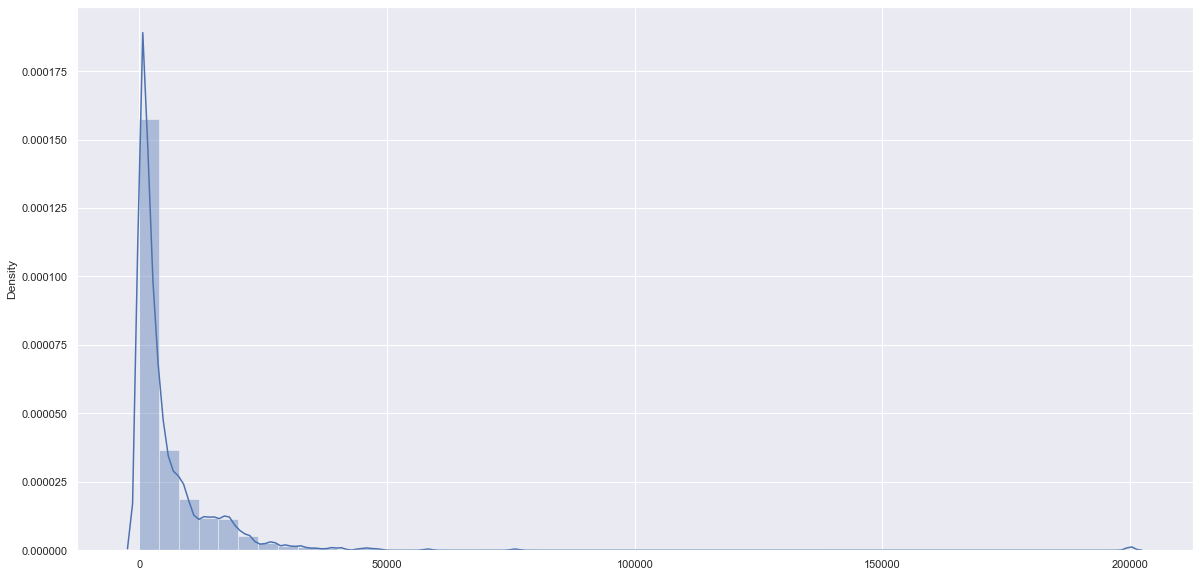

In [26]:
sns.distplot( df1[['competition_distance']] )

### 1.7.2. Categorical Attributes 

Categorical Attributes, ou variáveis categóricas, são os atributos que são influenciados em funcão da categoria a qual pertencem

In [155]:
str_attributes = df1.select_dtypes( exclude = ['float64','int64', 'datetime64[ns]'] )  #Only string variables

In [156]:
str_attributes.dtypes

state_holiday     object
store_type        object
assortment        object
promo_interval    object
month_map         object
dtype: object

In [157]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo?
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4,2015,0,31,2015,0,Jul,0


In [158]:
# Checking the number of levels which categorical variable possesses:
str_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

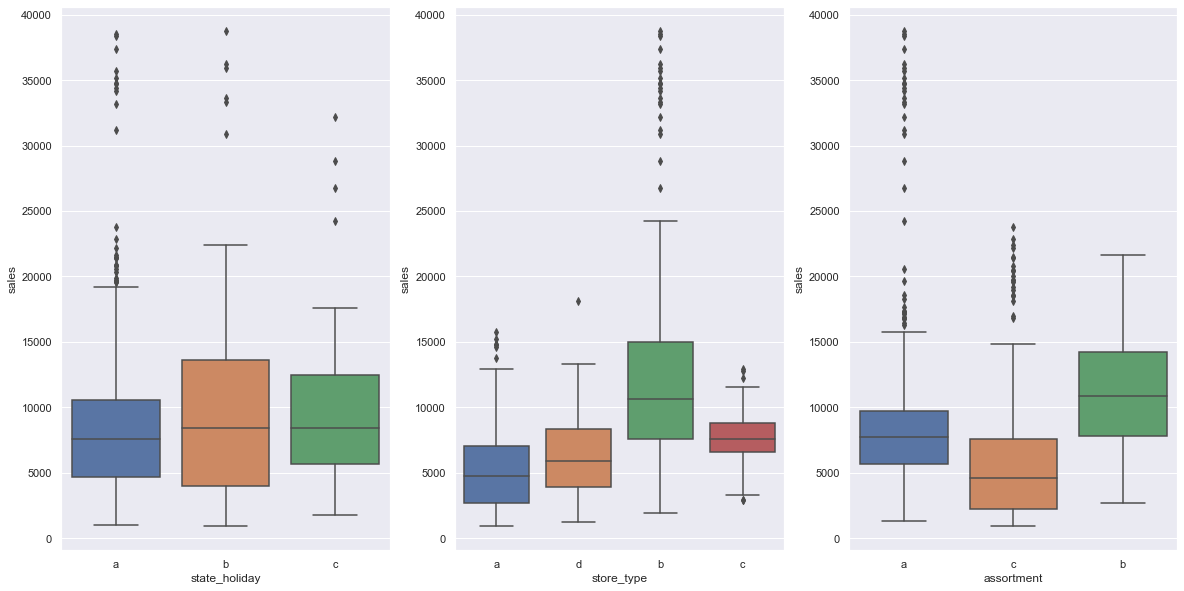

In [161]:
#It's necessary to disregard all sales that are null (= 0). Also, state holidays are not considered.

aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 );



# 2. (Passo 2) Feature Engineering

In [169]:
df2 = df1.copy()

## 2.0. Mind Map Hypothesis

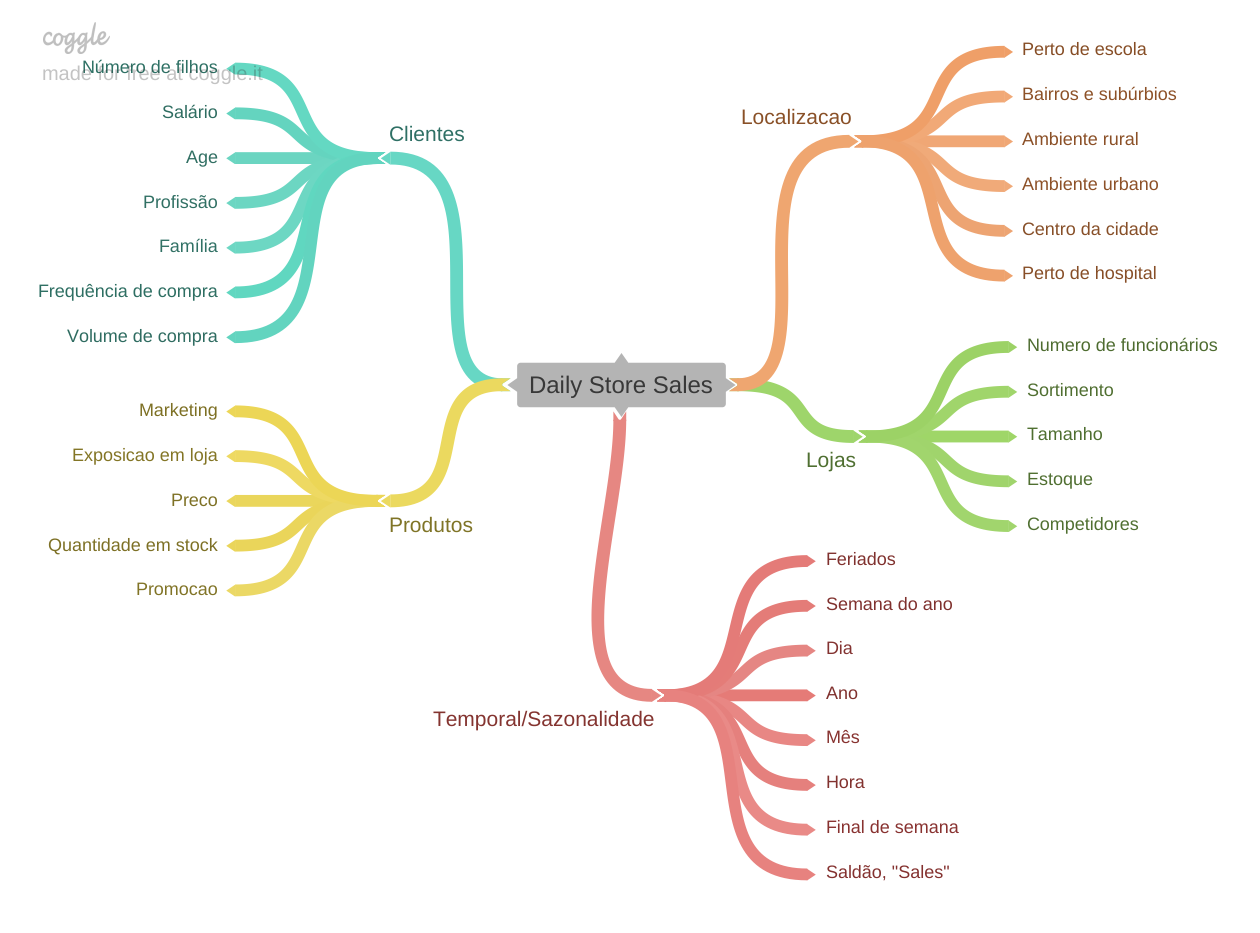

In [163]:
Image( 'Images/MindMapHypothesis.png' )

#  Verificar como diminuir o tamanho da imagem................

## 2.1. Creating the Hypothesis

### 2.1.1. Hypothesis for Stores

<s>**1.** Lojas com maior quadro de funcionários vendem 
mais.</s> 

<s>**2.** Lojas com estoque maior deveriam vender mais.</s> 

<s>**3.** Lojas com maior porte deveriam vende mais.</s>  

<s>**4.** Lojas com menor porte deveriam vende menos.</s>  

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores a mais tempo deveriam vender mais (Em comparacão as lojas com competidores a menos tempo).

### 2.1.2. Hypothesis for Products

<s>**1.** Lojas que investem mais em marketing deveriam vender mais.</s> 

<s>**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.</s>

<s>**3.** Lojas que tem precos menores pros produtos deveriam vender mais.</s>

<s>**4.** Lojas que mantém precos menores pros produtos por mais tempo deveriam vender mais.</s>

**5.** Lojas que promocoes mais agressivas (Descontos maiores) deveriam vender mais.

<s>**6.** Lojas com promocoes ativas por mais tempo deveriam vender mais.</s>

**7.** Lojas com mais dias de promocao deveriam vender mais.

**8.** Lojas com mais promocoes consecutivas (Em dias consecutivos) deveriam vender mais.

### 2.1.1. Hypothesis for Time (Seasonality)

**1.** Lojas abertas durante os feriados de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos (Quanto mais passa o tempo com uma loja aberta, mais ela vende em comparacao ao ano anterior).

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados  escolares.

## 2.2. Final List of Hypothesis (Priorization)

In [164]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo?'],
      dtype='object')

**Hypothesis for Stores**  

**1.** Lojas com maior sortimento deveriam vender mais 

('sales', 'assortment')

**2.** Lojas com competidores mais próximos deveriam vender menos. 

('sales', 'competition_distance')

**3.** Lojas com competidores a mais tempo deveriam vender mais. 

('sales', 'competition_open_since_month/year')


====================================================


**Hypothesis for Products** 

**4.** Lojas com promocões ativas por mais tempo deveriam vender mais. 

('sales', 'promo2_since_week/year')

**5.** Lojas com mais dias de promocão deveriam vender mais. 

('sales', 'promo_interval')

**6.** Lojas com promocões consecutivas (promocão -> promocão 2) deveriam vender mais. 

('sales', 'is_promo2?', 'promo_interval')

====================================================

**Hypothesis for Seasonality (Timing and Weather)** 

**7.** Lojas abertas durante os feriados de natal deveriam vender mais.

('sales', 'state_holiday')

**8.** Lojas deveriam vender mais ao longo dos anos. 

('sales', 'year')

**9.** Lojas deveriam vender mais no 1o semestre do ano. 

('sales', 'year', 'month')

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

('sales', 'year', 'month')

**11.** Lojas deveriam vender mais nos finais de semana. 

('sales', 'day', 'day')

**12.** Lojas deveriam vender menos durante os feriados escolares. 

('sales', 'day_of_week')

## 2.3. Feature Engineering - Deriving the variables

In [172]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month 

# day
df2['day'] = df2['date'].dt.day 


# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W') 


# ---------------------------------------------------------------------------------------------------

# COMPETITION (OPENED) SINCE

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], 
                                                                   month = x['competition_open_since_month'], 
                                                                   day = 1 ), axis = 1 )

#Atributo 'day' da funcão "datetime" = indica todo dia 1o de cada mês
#Atributo 'axis=1' indica que, pelo fato de eu estar usando 2 colunas diferentes, a funcão lambda é aplicada 
#na direcão do eixo 'x', i.e. na direcão das colunas.


df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

## Variável 'competition_time_month' = indica uma granularidade (mínima) de 1 mês, por isso divide por 30!
## Dentro da funcão lambda, usa-se o método 'days', o qual extrai os dias do datetime 'competition_time_month'

## Variável 'competition_time_month' => indica o período, desde que a competicão comecou, EM MESES

# ---------------------------------------------------------------------------------------------------

# PROMO SINCE

## Realizar um "join" das datas 'promo2_since_year' (Ano) e o 'promo2_since_week' (Semana do ano) a fim de converter 
## em uma só data:
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

## Nesse momento, a variável 'promo_since' é uma string, e não um datetime. Isso significa que ainda não é possível
## determinar o período entre a variável 'date' (datetime - data da venda) e a variável 'promo_since' (string - data de 
## início da promocão).


df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w'  ) - 
                                                         datetime.timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype(int) 

## Variável 'promo_time_week' => Indica o período, desde que a promocão consecutiva 'promo2' se iniciou, EM SEMANAS.

## Variável 'promo_time_week' = indica uma granularidade (mínima) de 1 semana, por isso divide por 7! 

# ---------------------------------------------------------------------------------------------------

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 
    

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x == 'a' else 'Easter holiday' if x == 'b' 
                                                            else 'Christimas' if x == 'c' else 'regular_day' )




/tmp/ipykernel_4645/175336725.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [173]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3. (Passo 3) Filtragem de Variáveis

In [174]:
df3 = df2.copy()

## 3.0. Check-point da Análise

In [175]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo?,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [176]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]

## 3.2. Selecão das Colunas

In [177]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )

In [178]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo?', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [ ]:
# Ao final da filtragem das linhas e selecao das colunas, resta apenas o datafram df3, o que representa o conjunto de
# dados importantes a serem utilizados para a análise. Todo o resto diferente é irrelevante e foi desconsiderado a
# partir da funcao 'drop'. 

# 4. (Passo 4) Análise Exploratória dos Dados (EDA)

In [179]:
df4 = df3.copy()

## 4.1. Análise Univariada 

### 4.1.1. Response Variable

/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


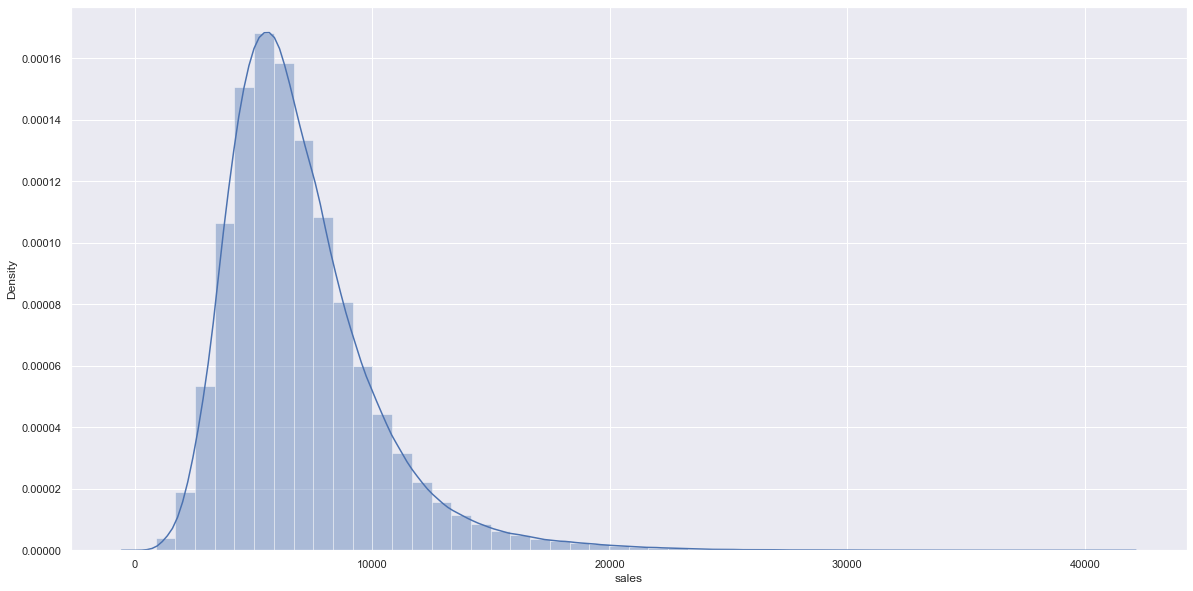

In [182]:
sns.distplot( df4['sales'], kde = True );

### 4.1.2. Numerical Variables

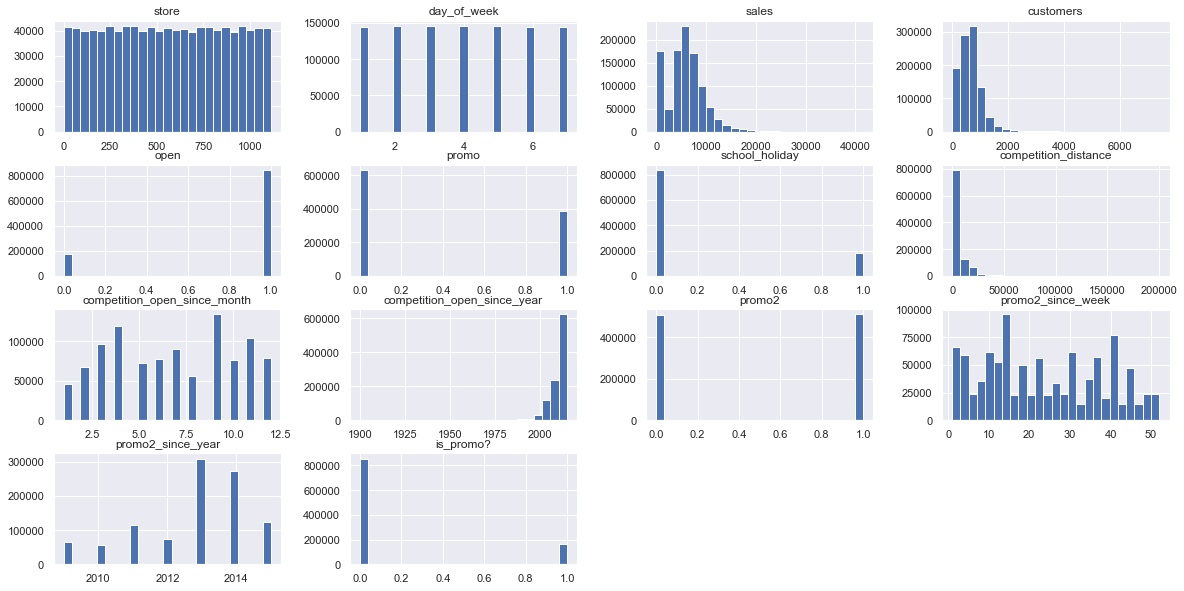

In [77]:
num_attributes.hist(bins = 25);

**# Análise inicial das variáveis numéricas (Um estudo mais aprofundado desses atributos será trabalhado durante a análise bivariada) #**

Os histogramas apresentados acima são relativos aos atributos pertencentes ao dataframe concatenado das variáveis do tipo 'int64' e 'float', i.e. somente valores numéricos. A análise é a seguinte (Da esquerda para a direita, do canto superior ao inferior):

1 - No primeiro gráfico, apesar de pouco apresentar, mostra o volume de vendas em funcão do ID de cada loja.

2 - Segundo o histograma, não existem grandes variacões no volume de vendas em funcão dos dias da semana. Talvez, durante a análise bivariada da hipótese da variacão de vendas em funcão do dia da semana, sejam mais facilmente observadas variacões dignas de importância.  

3 - Este mostra o mesmo comportamento do histograma anterior, com uma curtose acentuada e uma assimetria para a esquerda, indicando uma tendência de sem grandes variacões no volume de vendas.   

4 - Assim como o histograma do número de vendas, existe uma tendência de curtose acentuada e uma assimetria com relacão ao volume de clientes que acessam as lojas. Não existem períodos em que há mais do que 2500-3000 clientes acessando as lojas Rossmann no mesmo dia.  

5 - A variável 'open' não traz grandes informacões além do fato de retornarem valor '0' quando estão fechadas e '1' quando estão abertas: É neste último que estão concentrados as maiores vendas.  

6 - O histograma mostra a variacão no volume de vendas para quando existe promocão em período tradicional nas lojas (valor '1') e quando não existe nenhuma promocão em período tradicional ('0'), o que indica que um maior volume de vendas se concentra nos períodos em que não existem promocões, o que pode ser justificado pelo fato de que existem mais dias sem promocão do que dias com promocão.

7 - O histograma vendas x 'school holiday' mostra que, assim como o gráfico anterior ('promo' x 'sales'), o volume maior de vendas se concentra nos dias que não são feriados escolares, fato este justificado por não haverem tantos dias com feriados escolares.

8 - Neste gráfico, percebe-se uma tendência interessante: Quanto menor a distância entre o competidor mais próximo, maior o volume de vendas das lojas Rossmann, fato este que deverá ser analisado com maior atencão em algumas hipóteses.

9 - Existe uma variacão não linear do volume de vendas com relacão ao período, em meses, que o competidor mais próximo abriu a sua loja. 

10 - Neste histograma, percebe-se que competidores abertos a mais tempo influenciam nas vendas de forma a reduzi-las. Talvez não haja uma correlacão, uma vez que não se sabe quando as lojas Rossmann passaram a existir naquela região e, portanto, a fim de se enviar qualquer viés negativo, esta variável não deve ser analisada univariavelmente.

11 - A variável 'promo2', a qual indica se a loja participou da promocão consecutiva após o término da promocão de período tradicional, analisada separadamente, também não indica qualquer informacão se esta influencia o volume de vendas.

12 - Ao analisar a variável 'promo2_since_week', assim como a 'competition_open_since_month',  mostra uma variacão no volume de vendas em funcão do número de semanas que se passaram desde que a promocão consecutiva ('promo2') se tornou ativa. Entretanto, entende-se que existe um ligeiro descrescimento no número de vendas, o que pode indicar que, quanto mais o tempo que a promocão 2 está ativa, menor é o volume de vendas. Isso deverá ser analisado, separadamente, durante a análise bivariada.  

13 - Neste gráfico, assim como a 'promo2_since_week', é apresentado o volume de vendas em funcão do ano que a 'promo2' se tornou ativa. 

14 - Por fim, o último histograma da análise univariada da variável resposta mostra a influência da ativacão da promocão consecutiva no número de vendas: Percebe-se que não somente a promocão pouco influencia no número de vendas, como também existe uma diminuicão no número de vendas caso a promocão consecutiva seja ativada. Não é possível definir se existe, realmente, uma relacão direta entre os dois fatores e, a fim de evitar um enviesamento da análise, ambas devem ser analisadas em funcão de outra variável, como a distância entre a loja e o competidor mais próximo (**'competition_distance'**), o mês em que a promocão consecutiva se tornou ativa (**'promo2_since_week'**), etc.

### 4.1.3. Categorical Variables

In [42]:
# A reminder: 'Categorical Variables', ou variáveis categóricas, são somente as variáveis do tipo objeto (string).

In [184]:
str_attributes.head()

,state_holiday,store_type,assortment
0,0,c,a
1,0,a,a
2,0,a,a
3,0,c,c
4,0,a,a


In [186]:
df4['state_holiday'].drop_duplicates()  #Neste caso, serão retornados apenas os tipos de variáveis categóricas originais.

0            regular_day
63559     public holiday
129424    Easter holiday
241126        Christimas
Name: state_holiday, dtype: object

In [187]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [188]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/renanpacheco/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn

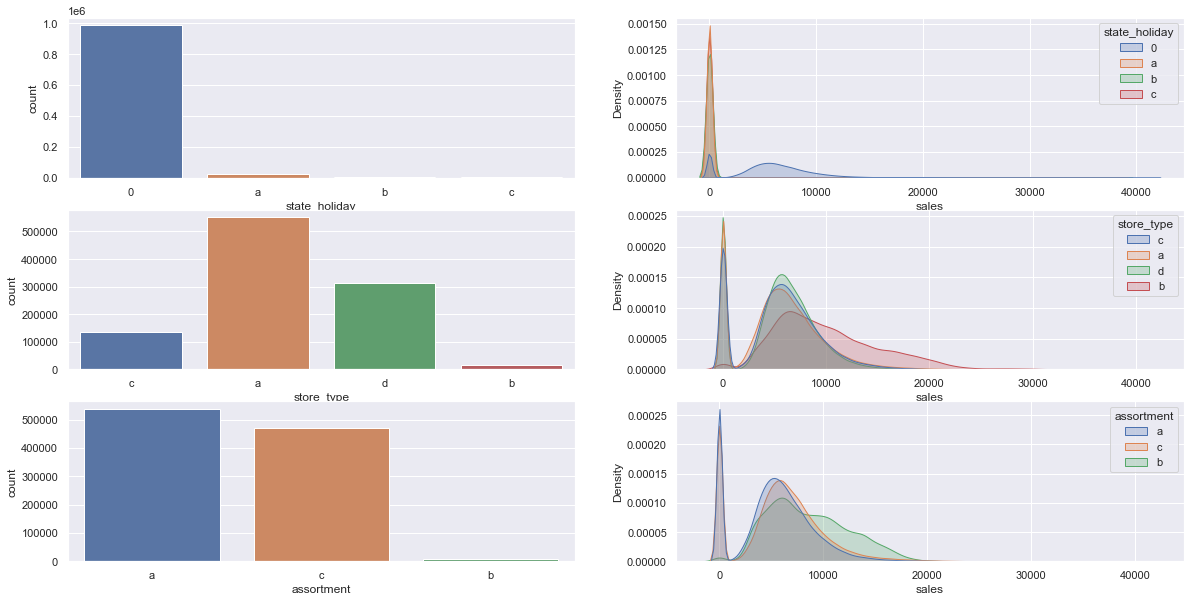

In [82]:
# state_holiday

# É preciso saber o volume de vendas para cada um dos 'state holidays' (Regular day, public holiday, easter holiday e
# Christimas), a fim de entender qual o tipo de feriado que mais impacta as vendas.


# Plotando o histograma da quantidade de vendas em funcao de cada tipo de feriado:
plt.subplot( 3, 2, 1 )
a = df4[ df4['state_holiday'] != 'regular_day' ]  #Neste caso, uma vez que 'regular_day está contido em 'state_holiday',
sns.countplot( a['state_holiday'] );              #ele não é considerado, somente os feriados.


# Plotando o gráfico das vendas em funcao da distribuicao de cada tipo de feriado. É mostrado a densidade de distribuicao,
# e o parâmetro 'hue' mapeia a densidade da influência de cada feriado nas vendas, distribuídas no eixo 'x':
plt.subplot( 3, 2, 2 )
sns.kdeplot( data = a, x = 'sales', hue = 'state_holiday', fill = True, common_norm = False );


# store_type

plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( data = df4, x = 'sales', hue = 'store_type', fill = True, common_norm = False );

# assortment:

plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] );    

plt.subplot( 3, 2, 6 )
sns.kdeplot( data = df4, x = 'sales', hue = 'assortment', fill = True, common_norm = False );


## 4.2. Análise Bivariada

### 4.2.1. H1 - Lojas com maior sortimento deveriam vender mais.

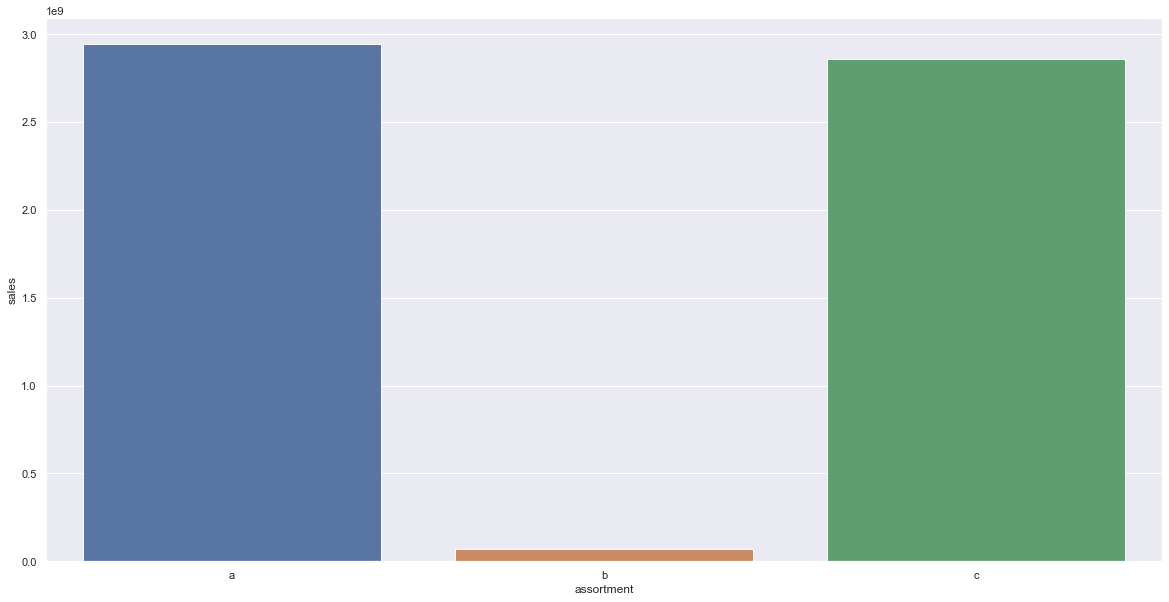

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot( x = 'assortment', y = 'sales', data = aux1 );

Avaliando o gráfico acima, é possível perceber que lojas com um assortment maior (i.g. lojas do tipo 'extra') possuem um volume de vendas menor em comparacão as lojas com um volume de assortment menor. No entanto, os dados não informam a diferenca entre os assortments do tipo 'extended assortment' e 'extra' e, portanto, não é possível assumir que as lojas do tipo 'extended assortment' possuem um volume de assortment maior em comparacão às lojas do tipo 'extra'.

Entretanto, é interessante validar a hipótese de que assortments do tipo 'extra' possuiam um grande volume de vendas no passado mas que, em funcão de alguma influência externa (Ou de algum atributo não analisado), houve essa reducão drástica..

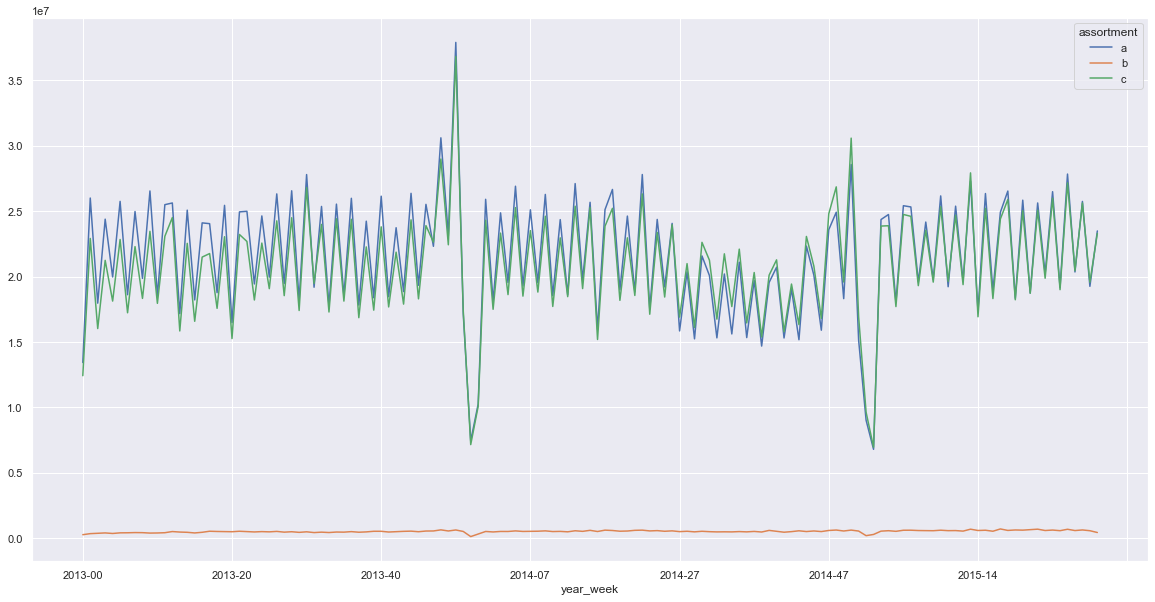

In [52]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

aux2.pivot( index = 'year_week',  columns = 'assortment', values = 'sales' ).plot();

Pode-se observar que o volume de vendas dos assortments do tipo 'basic' e 'extended' possuem comportamentos muito semelhantes ou praticamente iguais, em detrimento do assortment do tipo 'extra', que possui um volume de vendas extremamente baixo e comportamento linear.

Porém, pode ser interessante verificar se tal comportamente é realmente linear ou se existe alguma variacão que pode ser influenciada por outras variáveis...

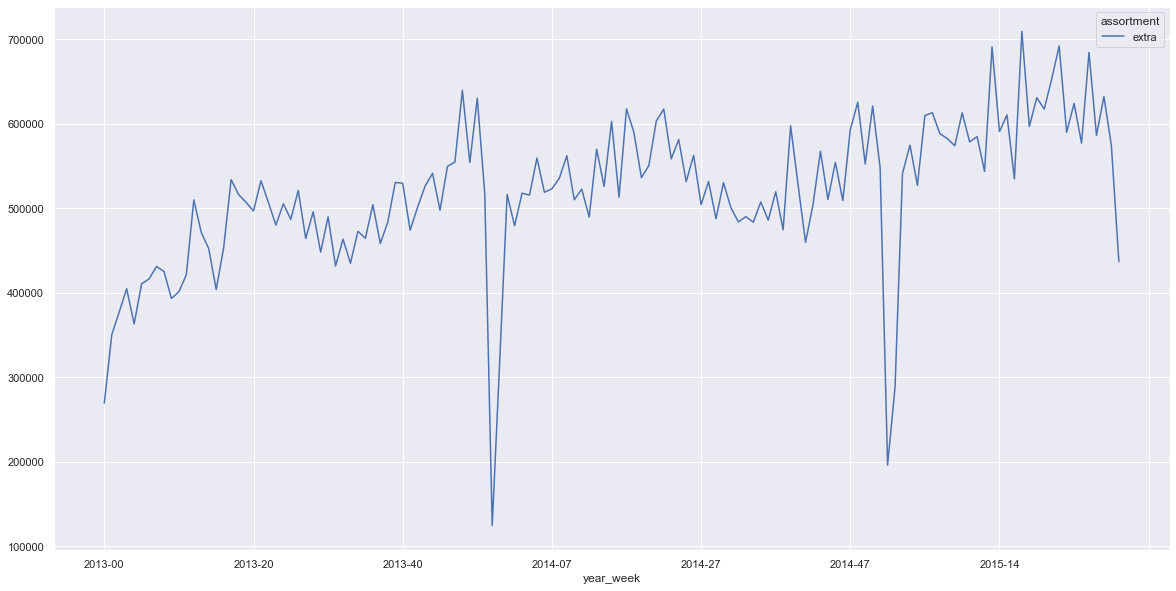

In [64]:
aux3 = aux2[ aux2['assortment'] == 'extra' ]

aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot();

**Conclusão**

Pela análise dos gráficos, percebe-se que lojas com maior sortimento ('assortment' do tipo "extra") na verdade vendem menos, em comparacão com as lojas com menor sortimento. Pela análise das micro-flutuacões presentes tanto nos sortimentos do tipo "basic" e "extendend" quanto no do tipo "extra", é notória a relevância da variável 'assortment' para o modelo, uma vez que, ao se analisar multivariavelmente, é possível que esta possa influenciar (Ou ser influenciada) por outras variáveis, como o feriado predominante ('state_holiday') ou então a distância entre a loja Rossmann e o competidor mais próximo.

Além disso, é notória a influência (Talvez não direta - Evitar o enviesamento da análise) da sazonalidade nos sortimentos.

Hipótese "lojas com maior sortimento deveriam vender mais" -> **FALSA**

Conclusão: Lojas com maior sortimento vendem menos, comparativamente.

**Aplicacão da variável no modelo:** Apesar de haver uma conclusão totalmente contra-intuitiva, uma vez que traz a ideia de que lojas com maior sortimento na verdade vendem menos, existem 3 tipos diferentes de sortimentos, 2 muito iguais e 1 completamente diferente, apresentando 2 comportamentos diferentes para a mesma variável.

### 4.2.2. H2 - Lojas com competidores mais próximos deveriam vender menos.

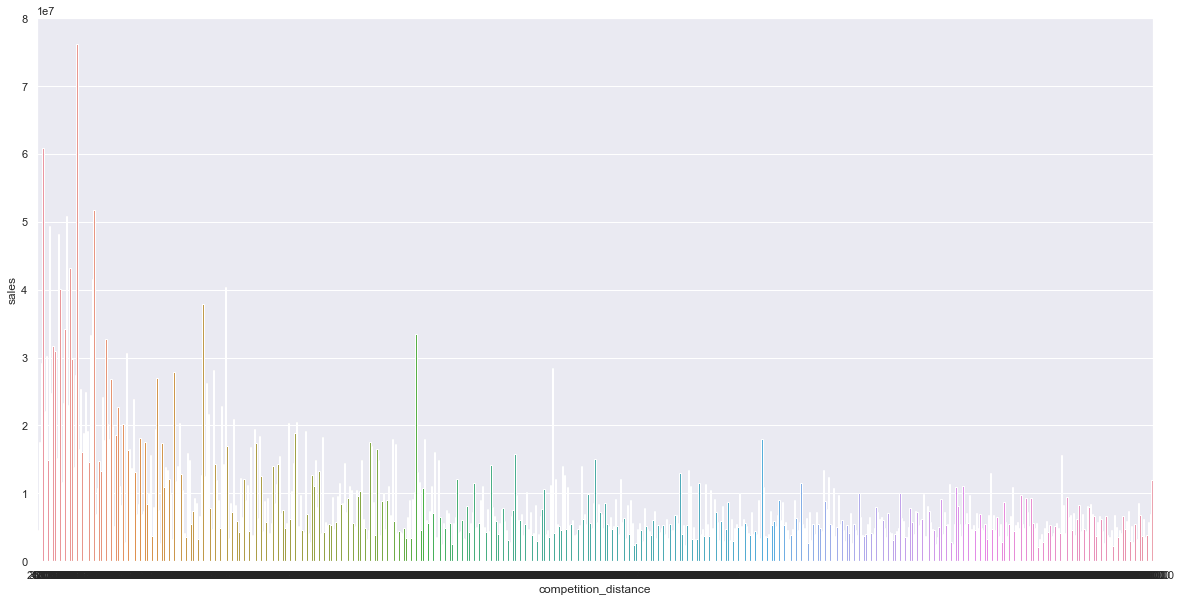

In [65]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

sns.barplot( x = 'competition_distance', y = 'sales', data = aux1  );

Entretanto, o gráfico acima é extremamente granular e de difícil visualizacão, uma vez que nenhum dado pode ser obtido.

Ao agrupar um determinado grupo de valores que fazem parte da variável 'competition_distance' em diferentes grupos e, portanto, agregando um número grande de valores, facilita a visualizacão...

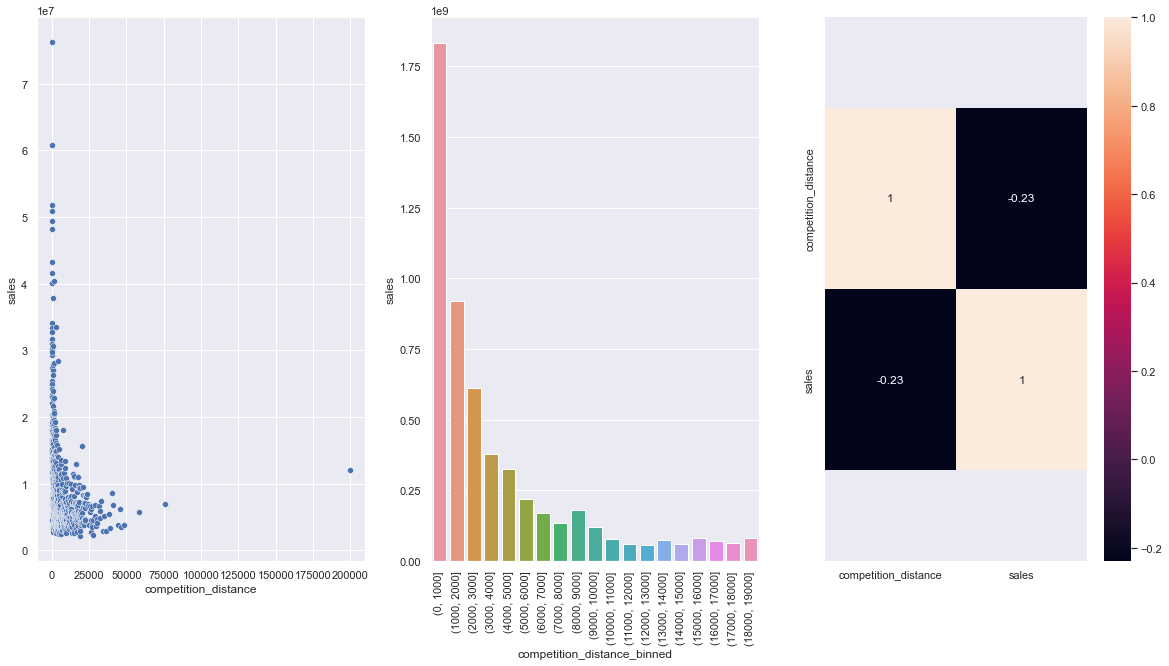

In [66]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


plt.subplot( 1, 3, 1 )
sns.scatterplot( x= 'competition_distance', y = 'sales', data = aux1 );


plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins ) 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot( x= 'competition_distance_binned', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );


plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method = 'pearson'), annot = True );
bottom, top = x.get_ylim()

x.set_ylim( bottom + 0.5, top - 0.5 );

**1o e 2o gráficos:**
A hipótese diz que "lojas com competidores mais próximos deveriam vender menos". Isso porque a presenca de competicão faz com que hajam mais opcões de compra para os compradores e, portanto, existe um compartilhamento das vendas maior. Portanto, quanto mais próximos estão os competidores, maior a concorrência e, consequentemente, menor as vendas.

Entretanto, à partir da análise dos gráficos apresentados acima, pode-se perceber que, com competidores mais próximos (distâncias menores do que 1000m - 1a tabela do histograma), as lojas apresentam um maior número de vendas. Isso vai de oposto para com a hipótese.

**3o gráfico:**

Conforme mostra no 3o gráfico, a correlacão entre as variáveis 'competition_distance' e 'sales' é de -0.23, o que apresenta um bom valor, uma vez que quanto mais próximo de +1 e/ou -1, melhor a correlacão. 

O valor de -0.23 significa que, quanto mais distante o concorrente se encontra com relacão às lojas Rossmann, menor a venda daquela loja, ou seja, uma correlacão inversamente proporcional. 

**Conclusão**

Hipótese "lojas com competidores mais próximos deveriam vender menos" -> **FALSA**

Conclusão: Lojas com competidores mais próximos vendem mais.

**Aplicacão da variável ao modelo:** Pelo fato da refutacão da hipótese trazer um insight, a variável 'competition_distance' pode ser um parâmetro relevante para o modelo, mesmo tendo uma forca de correlacão de -0.23.

### 4.2.3. H3 - Lojas com competidores a mais tempo deveriam vender mais (Em comparacão as lojas com competidores a menos tempo).

O interessante desta hipótese é a análise do tempo desde que a competicão se iniciou (Quando o competidor mais próximo abriu a loja) e como isso influencia nas vendas.

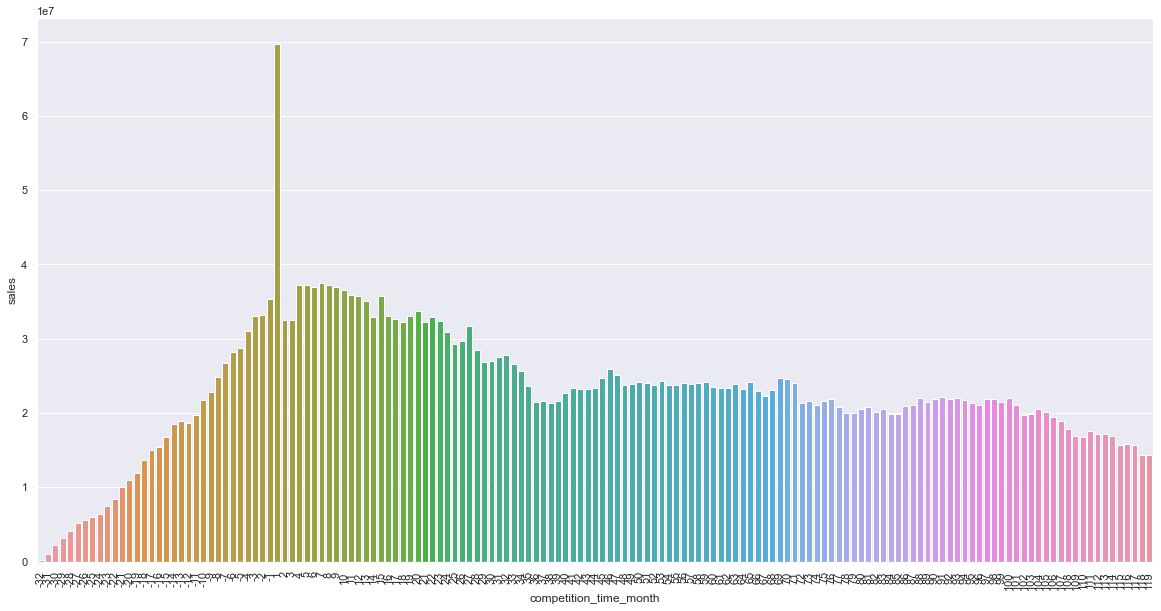

In [67]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

A variável 'competition_time_month' foi derivada a partir da diferenca entre a variável relativa à data da venda atual ('date') e a data que o competidor mais próximo abriu ('competition_open_since_month', no caso). Isso quer dizer que se a venda aconteceu em uma data mais atual com relacão à abertura do competidor, o valor da variável 'competition_time_month' terá valores positivos. Entretanto, caso o competidor ainda não tenha aberto a sua loja, o valor da variável será negativo.

Conforme apresenta o histograma acima, pode-se perceber que valores próximos de zero possuem um volume de vendas maior. Isso significa que quanto mais recente é a abertura da competicão, maior é a quantidade de vendas.

É interessante buscar entender, ainda, a forca da correlacão entre a variável do volume de vendas ('sales') e o mês que o competidor mais próximo abriu alguma loja...

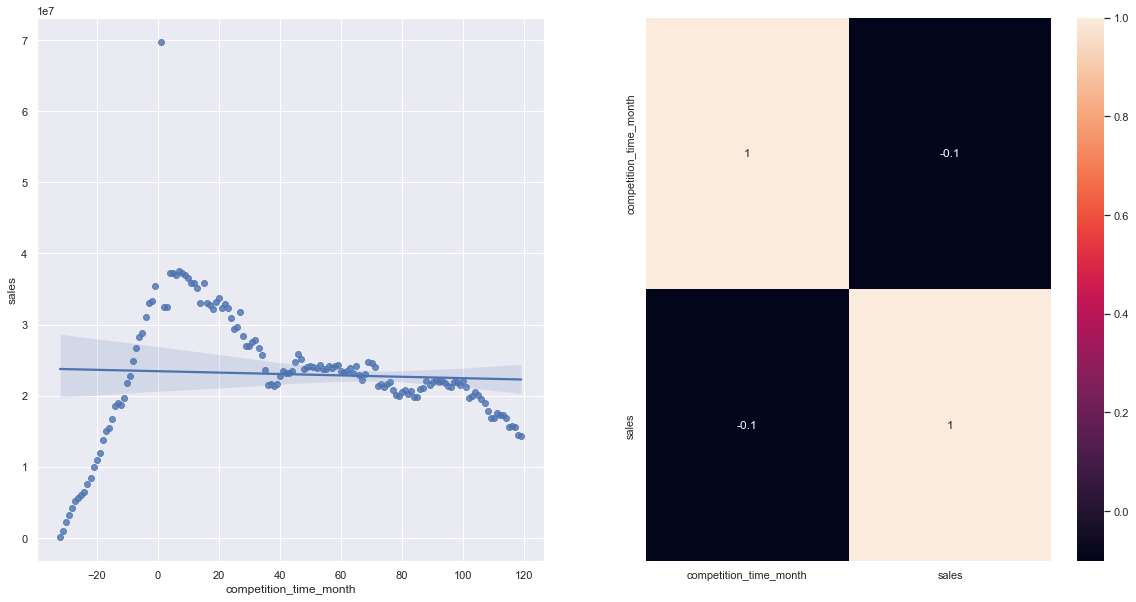

In [68]:
plt.subplot( 1, 2, 1 )
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2 )

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );
bottom, top = x.get_ylim()
x.set_ylim( bottom + 0.5, top - 0.5 );  #método usado para bugs da versão do seaborn quando os números das correlacões
                                        #são possicionados muitos ao extremo do gráfico.

**Gráfico a esquerda**
O gráfico de correlacão acima mostra o mesmo comportamento mostrado pelo histograma com uma granulacão um pouco maior, porém com uma linha de tendência caindo, o que indidica a correlacão de que quanto maior o tempo de competicão, menor o volume de venda. Entretanto, não é possível basear a análise somente nessa linha de tendência linear, uma vez que o comportamento não é linear. Isso pode enviesar a análise ao erro. 

**Gráfico a direita**
A partir do gráfico, a correlacão entre a variável 'competition_time_month' em relacão a variável resposta que, no caso, é a variável 'sales', é de -0.1, valor este suficiente para a análise: Correlacões próximas de 0 possuem menos relevância e, apesar de estar longe de +1 e -1, pode ser utilizada.

**Conclusão**

Hipótese "lojas com competidores a mais tempo deveriam vender mais" -> **FALSA**

Conclusão: Lojas com competidores a mais tempo vendem menos, comparativamente.
           Lojas com competidores a menos tempo vendem mais.
           
**Aplicacão da variável ao modelo:** Baixa aplicacão devido à baixa correlacão da variável com a variável-reposta.

### 4.2.4. H4 - Lojas com promocoes ativas por mais tempo deveriam vender mais.

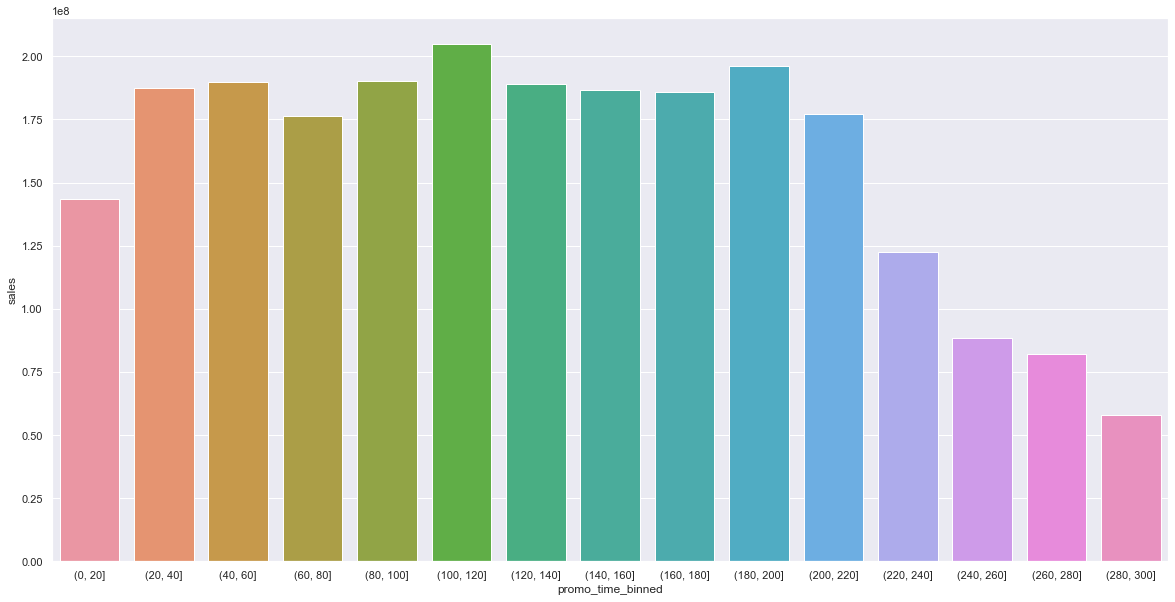

In [69]:
# Variável 'promo_time_week' = indica quantas semanas se passaram desde o início da ativacão da promocão consecutiva (promo2).

aux1 = df4[ ['promo_time_week', 'sales'] ].groupby('promo_time_week').sum().reset_index()

bins = list( np.arange( 0, 313, 20 ) )
aux1['promo_time_binned'] = pd.cut( aux1['promo_time_week'], bins = bins )

aux2 = aux1[ ['promo_time_binned', 'sales'] ].groupby('promo_time_binned').sum().reset_index()

sns.barplot( x = 'promo_time_binned', y = 'sales', data = aux2 );

O gráfico acima mostra que, no período de 10 à 120 semanas desde o início da promocão, o volume de vendas foi maior. Isso claramente já **refuta** a afirmacão de que lojas com promocões ativas por mais tempo vendem mais, uma vez que lojas com promocão ativa por um período entre 260 à 280 semanas e de 280 à 300 semanas na verdade venderam menos, comparativamente. O descrescimento é claro.

Uma outra forma de fazer essa análise é...

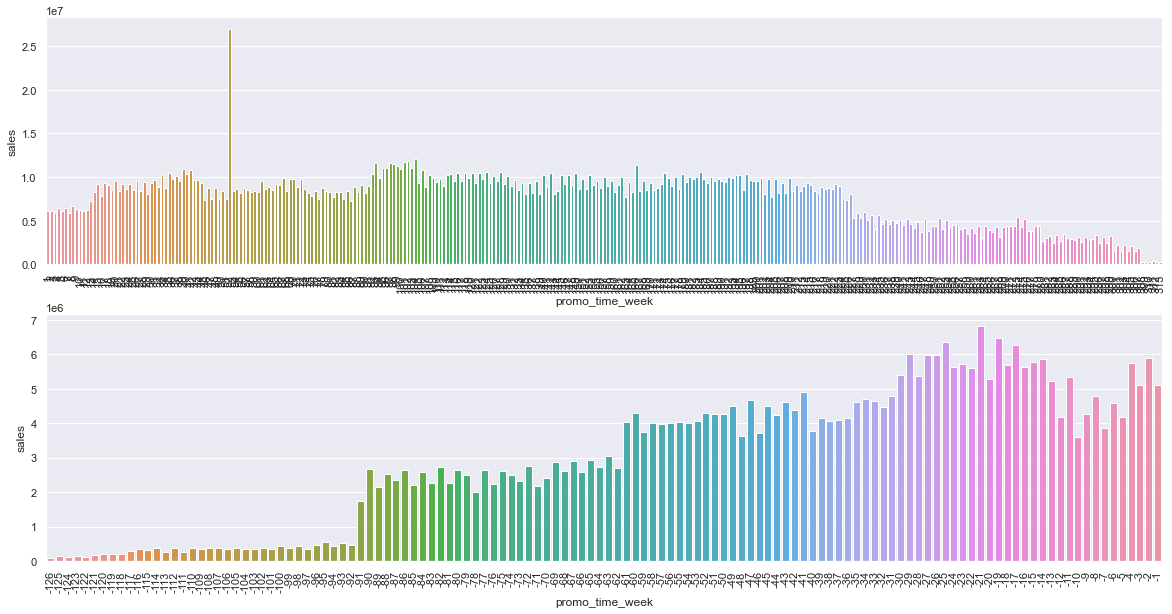

In [70]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot( 2, 1, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0]  #período de promocão extendido
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 2, 1, 2 )
aux3 = aux1[ aux1['promo_time_week'] < 0 ]  #período de promocão regular
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3 );
plt.xticks( rotation = 90 );

***Gráfico superior***

O gráfico superior apresenta a variável 'promo_time_week' (Diferenca entre a data atual e a data de início da promocão) com valores positivos, representando a promocão extendida, i.e. a promocão iniciou antes da data de hoje e continua.

Percebe-se, pelo gráfico, que um grande volume de vendas se mantém constante até um certo período de tempo até que comeca a decair, isto é, ela possui um tempo determinado que ela irá funcionar. Após esse tempo, o volume de vendas naturalmente decai.


***Gráfico inferior***

Percebe-se que, em períodos próximos do início da promocão (diferenca entre o período de venda e o período de início da promocão apresenta valor negativo), existem saltos nas vendas, o que pode ser resultado das acões do marketing. Porém, períodos de início da venda muito aquém do início da promocão praticamente não possuem venda alguma, uma vez que não atingem o consumidor de forma direta.

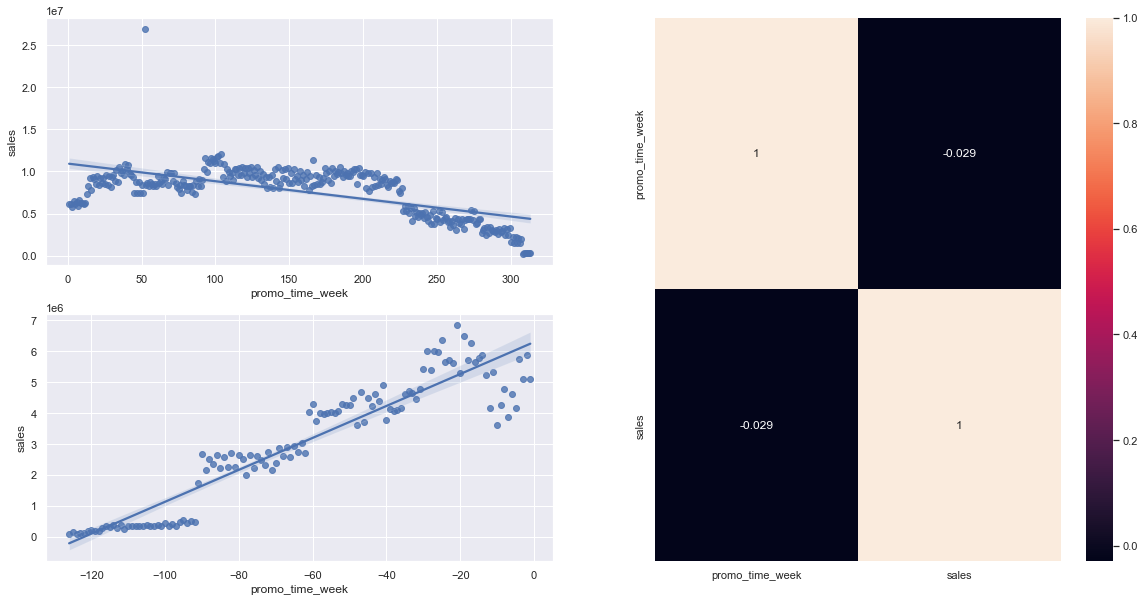

In [71]:
grid = GridSpec( 2, 2 )

plt.subplot( grid[0, 0] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot( grid[1,0] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( grid[:,1] )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

#aux1 = refere-se ao período de promocao extendida, i.e. a diferenca entre a data da venda (hoje) e o início da promocão 2 
#(variável 'promo_since', que deriva da variável 'promo2_since_year').

**Gráfico superior aesquerdo:**
O primeiro gráfico à esquerda representa o conjunto de dados 'aux2', o que engloba períodos de extensão da promo2 positivos, i.e. a venda ocorre após o início da promocão. Isso mostra que o crescimento no volume de vendas ocorre de forma indiretamente proporcional à quantidade de semanas que se passaram. Ou seja: Quanto mais próximo do início da promocão, maior o volume de vendas e, quanto mais tempo se passa desde o início da promocão, menos vendas são feitas. Isso por si já desvalida a hipótese.   


**Gráfico inferior à esquerdo:**
Já o gráfico inferior esquerdo mostra, a partir do conjunto de dados 'aux3', períodos de início da promocão negativos, i.e. as vendas são registradas antes do início da promocão. Isso mostra que, caso seja feito o marketing de uma promocão que será ativada muito à frente do futuro, isso não influencia na venda atual.    


**Gráfico de correlacão (Heatmap) à direita:**
A correlacão apresentada pelo gráfico sobre a variável 'promo_time_week' em funcão da variável-resposta 'sales' apresenta uma correlacão de -0.03, o que representa uma correlacão extremamente fraca. Uma vez que o gráfico é a representacão visual do dataframe 'aux1', o qual simboliza o período entre a data da venda (atual) e a data de início da promo2, o valor negativo indica uma fraca correlacão negativa, i.e. além da correlacão entre ambas as variáveis serem baixas, também é inversamente proporcional.

Tal correlacão ser fraca pode ser justificado pelo fato de haver um grande período com volume de vendas constante. Tal diminuicão no número de vendas não está relacionado com o fato do início da promocão estar próxima ou distante e, portanto, outra variável pode influenciar no modelo.

**Conclusão**

Hipótese "lojas com promocões ativas por mais tempo deveriam vender mais" -> **FALSA**

Conclusão: Lojas com promocões ativas por mais tempo vendem menos, comparativamente. Essas lojas com promocões ativas vendem até um certo período e, após isso, o volume de vendas tende a decair.

**Conclusão da correlacão:** A feature de correlacão entre o período que a promo2 está ativa ('promo_time_week') não é tão relevante para o modelo. Espera-se analisar de essa feature pode ou não combinar com outra feature e, assim, ter relevância.

### <s> 4.2.5. H5 - Lojas com mais dias de promocao deveriam vender mais. </s>

**=======> ESSA HIPÓTESE SERÁ ANALISADA DURANTE O 2o CICLO DO CRISP!!! <=======**

### 4.2.6. H6 - Lojas com mais promocoes consecutivas (Em dias consecutivos) deveriam vender mais.

Essa hipótese irá avaliar se lojas que entram no período consecutivo de promocão (da promocão tradicional à promocão de número 2 - 'promo2') vendem mais ou não...

In [72]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

#variável 'promo' = indica se a loja está no período tradicional de promocão

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Análise da tabela:

1. Lojas que não participaram de nenhuma das promocões
2. Lojas que participaram somente da promo1 e não da promo2
3. Lojas que participaram somente da promo2 e não da promo1
4. Lojas que participaram de ambas as promocões 1 e 2

Percebe-se que as lojas que participaram somente da promo2 e não da promo1 tiveram menos vendas em comparacão com as lojas que participaram de ambas as promocões ou então que não participaram de nenhuma promocão.

**Pela análise individual da tabela, percebe-se a tendência de que, quando as lojas participam somente da promocão 2 ou de ambas as promocões 1 e 2, o volume de vendas é menor, comparado com quando participam somente da promocão 1 ou quando não participam de nenhuma promocão.**

Porém, as lojas que participaram somente da promocão 1 mas não da promocão extendida 2 tiveram um maior volume de vendas, comparativamente. Portanto, **a hipótese não é verdadeira.**

-----------------------------------------------------------

Pode-se, ainda, buscar entender se esse comportamento teve alguma flutuacão ao longo do tempo, i.e. se as lojas que participaram de somente uma das promocões (em período tradicional ou extendido) tiveram alguma mudanca de comportamento, ou se realmente ambos os atributos não possuem nenhuma correlacão entre si...

(variáveis 'sales', 'promo', 'promo2', 'promo_time_week')

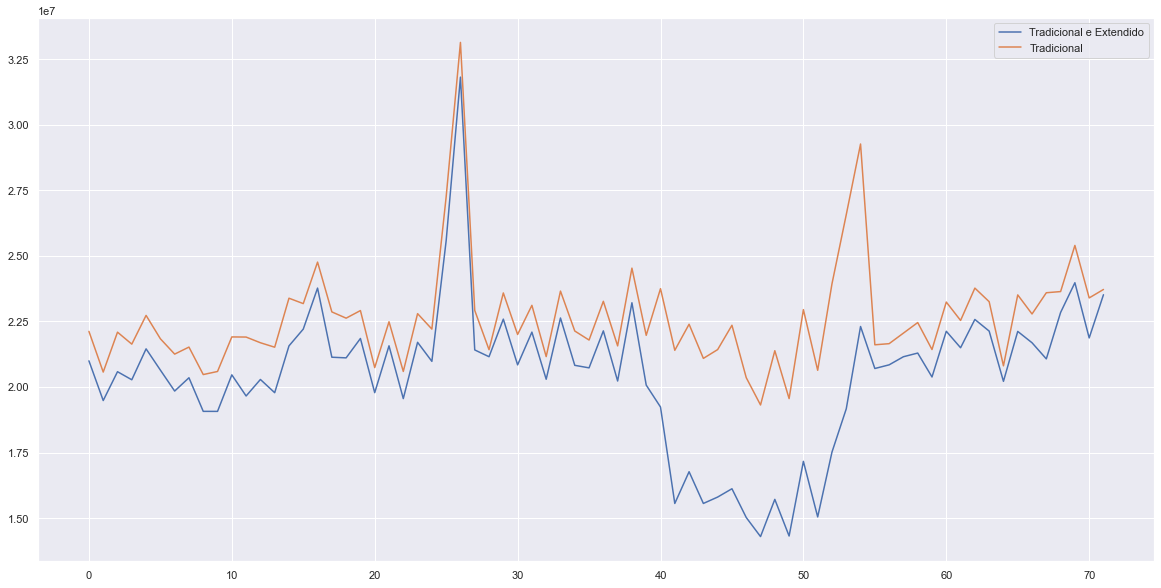

In [73]:
aux1 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 1) ][['year_week',
                                                          'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot();

aux2 = df4[ (df4['promo'] == 1) & (df4['promo2'] == 0) ][['year_week',
                                                          'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax );

ax.legend( labels = ['Tradicional e Extendido', 'Tradicional'] );

O gráfico acima mostra as lojas que participaram de ambos os períodos de promocão (Em azul) e somente do período tradicional. Percebe-se que o comportamento do volume de vendas das lojas que participaram de ambas as promocões e somente da promocão tradicional é praticamente o mesmo, salvo por um curto período que influencia o volume de vendas das lojas que participaram de ambas as promocões.

Conclui-se, portanto, que a hipótese de que as lojas que tem promocões ativas por mais tempo (Período tradicional + período extendido) deveriam vender mais é **falsa**, uma vez que mesmo que o comportamento siga o mesmo padrão, em termos de número de vendas acaba sendo menor.

Em termos de relevância como feature para o modelo, não deve ser tão interessante de ser utilizado como feature. 

**Conclusão**

Hipótese "lojas com promocões ativas por mais tempo deveriam vender mais" -> **FALSA**

Conclusão: Lojas com promocões ativas por mais tempo, i.e. com promocões consecutivas, vendem menos, comparativamente.

**Aplicacão da variável ao modelo:** Pelo fato das variáveis 'promo' e 'promo2' possuirem comportamento muito semelhante, salvo uma pequena parte, a forca da relevância é baixa, mas que pode ser aplicada a fim de gerar algum insight a respeito do 'shift' de comportamento do volume de vendas das lojas que participaram do período de promocão tradicional + extendido.  

### 4.2.7. H7 - Lojas abertas durante os feriados de Natal deveriam vender mais.

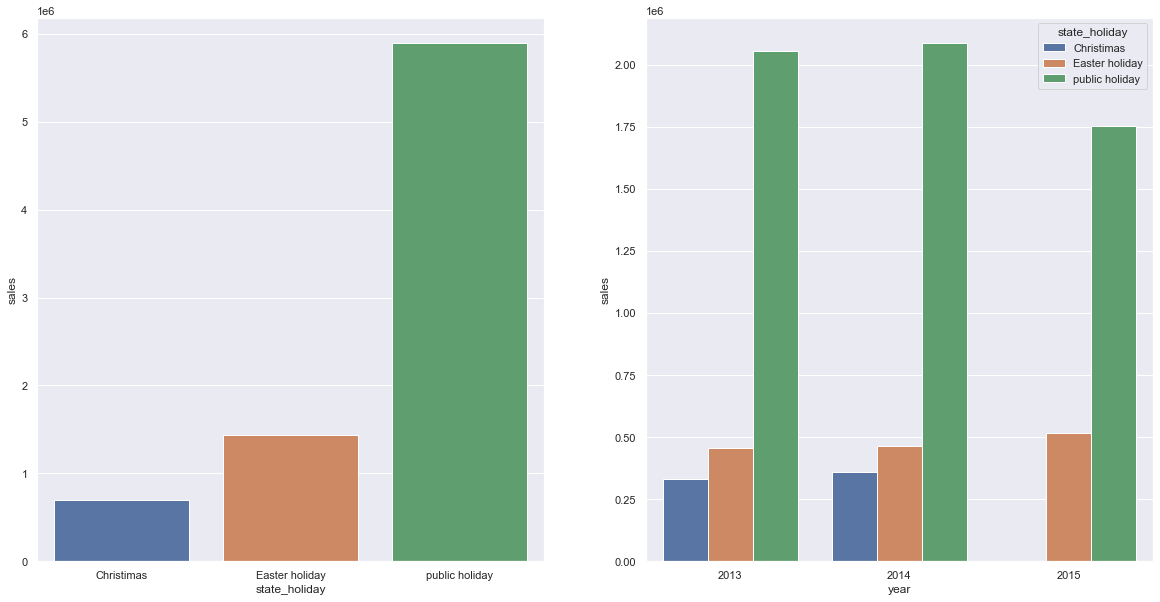

In [189]:
aux = df4[ df4['state_holiday'] != 'regular_day' ]

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2 );

A partir da análise do gráfico superior, é possível perceber que o volume de vendas no feriado de Natal é menor do que os feriados públicos e feriado de Páscoa, comparativamente.

É interessante analisar se já ocorreu algum tipo de 'shift', i.e. se em algum momento o feriado de Natal já chegou a vender mais do que outros feriados estaduais. Pelo gráfico da direita, é possível perceber que, no decorrer dos anos de 2013, 2014 e 2015 (Ano atual), as vendas nos feriados públicos, comparacão com o Natal, vendem muito mais.

**Conclusão**

Hipótese "lojas abertas durante o feriado de natal vendem mais, ou deveriam vender mais -> **FALSA**

Conclusão: Lojas abertas durante o feriado de Natal vendem menos em relacão aos outros tipos de feriados (Feriqados públicos e feriado de páscoa, comparativamente

### 4.2.8. H8 - Lojas deveriam vender mais ao longo dos anos (Quanto mais passa o tempo com uma loja aberta, mais ela vende em comparacao ao ano anterior).

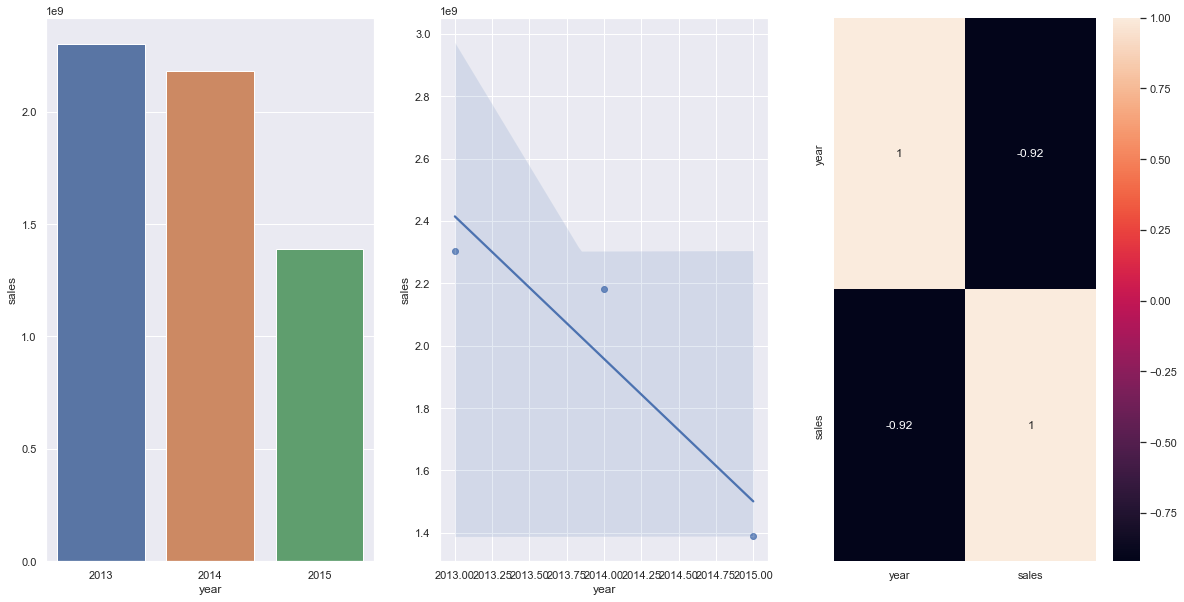

In [75]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

Pelo gráfico da esquerda, a tendência do volume de vendas é de queda...

Pela análise da tendência e forca da correlacão entre as variáveis 'year' e 'sales', percebe-se que a forca da correlacão entre os anos e o número de vendas é extremamente forte, com valor de -0.92, o que significa que, ao longo dos anos, quanto maior o número de anos se passa, menor o número de vendas, algo extremamente preocupante. 

**Conclusão**

Hipótese "lojas tendem a vender mais ao longo dos anos  -> **FALSA**

Conclusão: Existe uma tendência das lojas venderem menos ao longo dos anos. O ano final analisado, de 2015, ainda não está completo, então provavelmente a forca da correlacão pode diminuir um pouco, porém é diretamente proporcional com o número de vendas, indicando uma métrica, apesar de não ser um insight, influencia diretamente no revenue da empresa e deve ser analisada a partir de hipóteses multivariadas.

### 4.2.9. H9 - Lojas deveriam vender mais no segundo semestre do ano.

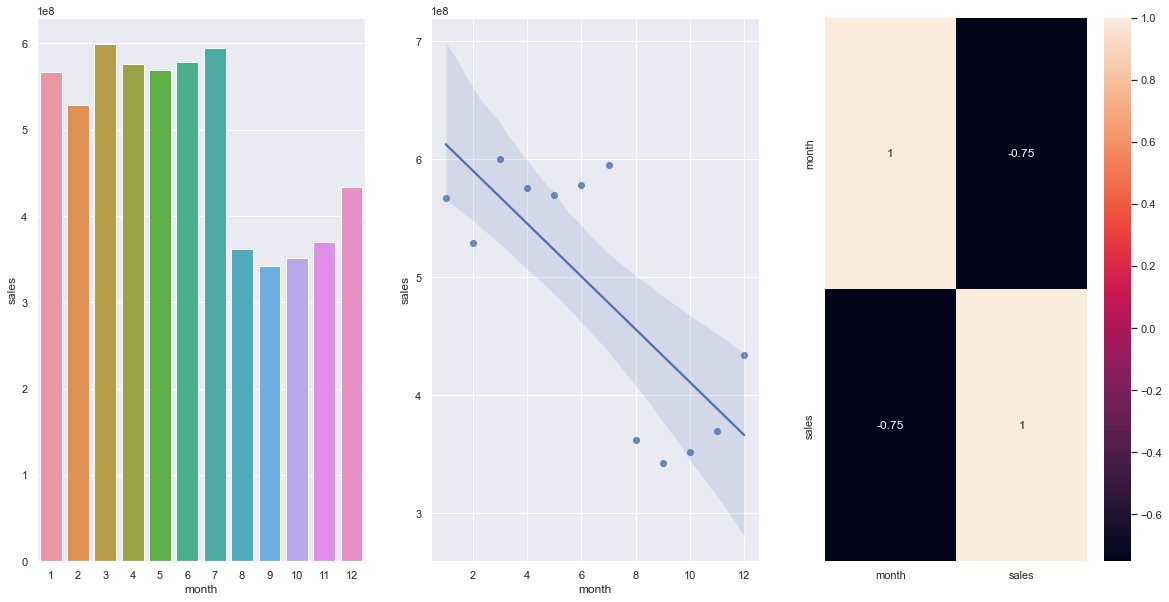

In [76]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

Conforme pode-se perceber a partir do 1o gráfico, existe uma clara tendência em se manter o volume de vendas em patamares elevados nos primeiros 6 meses do ano, independente de qual ano seja (2013, 2014 e/ou 2015). Após o 1o semestre, a tendência é que o volume de vendas diminua consideravelmente.

O mapa de calor apresentado no 3o gráfico mostra uma correlacão extremamente elevada negativamente, de -0.75, o que indica que quanto mais o tempo passa, menor o número de vendas (x cresce enquanto y decresce).

Além disso, é notória a importância dessa variável (Ou desse tipo de análise bivariável) para o modelo, uma vez o algoritmo pode entender que, se as vendas estiverem ocorrendo no 2o período/semestre de algum ano, uma análise preditiva irá mostrar a queda acentuada no volume de vendas.

**Conclusão**

Hipótese "lojas deveriam vender mais no 2o período do ano -> **FALSA**

Conclusão: Lojas vendem menos no 2o período do ano em comparacão com o 1o período do mesmo ano.

### 4.2.10. H10 - Lojas deveriam vender mais depois do dia 10 de cada mês.

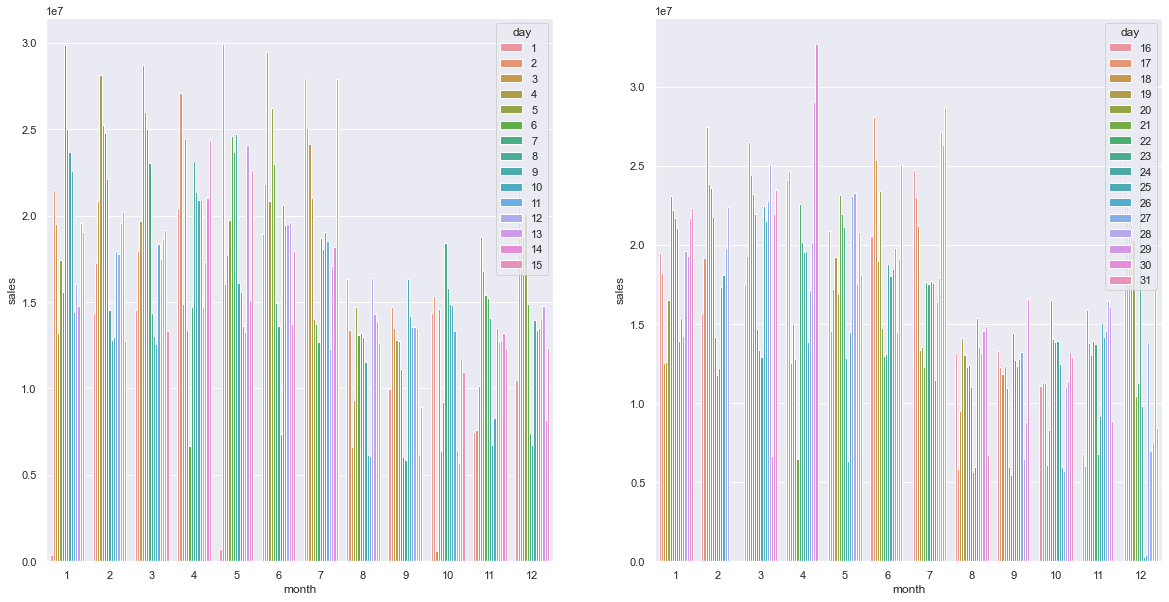

In [77]:
plt.subplot( 1, 2, 1 )
aux_before_15 = df4[ ( df4['day'] <= 15 ) ]

aux1_before_15 = aux_before_15[['month', 'day', 'sales']].groupby(['month', 'day']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'day', data = aux1_before_15 );

plt.subplot( 1, 2, 2 )
aux_after_15 = df4[ ( df4['day'] > 15 ) ]

aux1_after_15 = aux_after_15[['month', 'day', 'sales']].groupby(['month', 'day']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'day', data = aux1_after_15 );

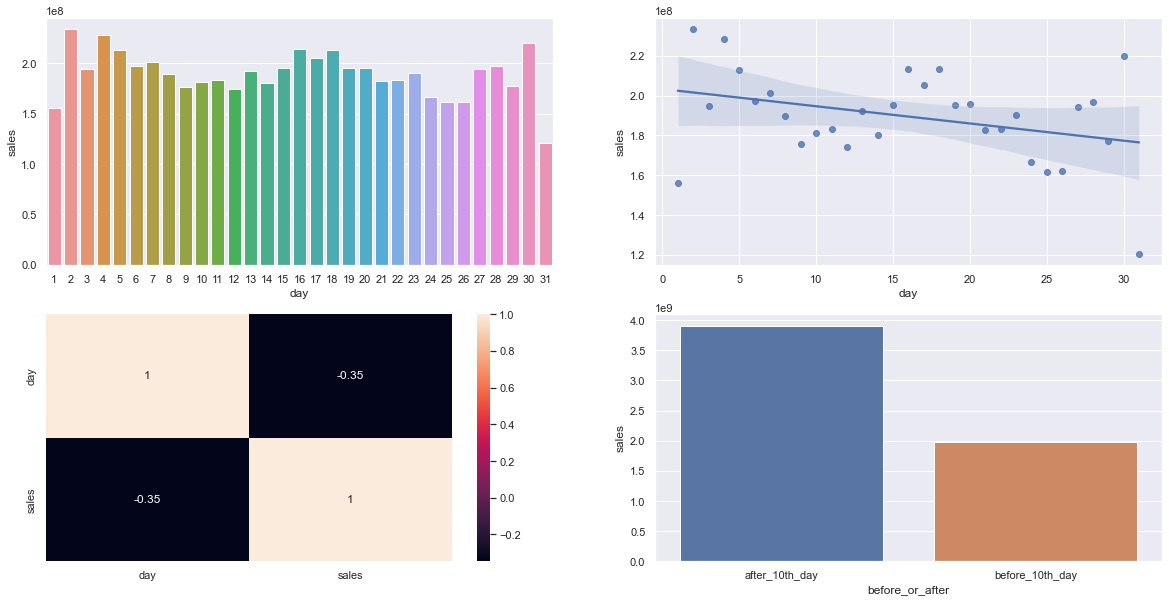

In [81]:
aux1 = df4[ ['day', 'sales'] ].groupby('day').sum().reset_index()

aux1['before_or_after'] = aux1['day'].apply( lambda x: 'before_10th_day' if x <=10 else 'after_10th_day' )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

plt.subplot( 2, 2, 4 )
aux2 = aux1[ ['before_or_after', 'sales'] ].groupby('before_or_after').sum().reset_index()
sns.barplot( x = 'before_or_after', y = 'sales', data = aux2 );

A partir do gráfico superior, é possível perceber a tendência apresentada na hipótese 9 à respeito do número de vendas que decaem a partir do 2o semestre do ano, com relacão ao 1o semestre.

Mas além disso, mostra outra tendência dentro de cada mês: Existe uma variacão no volume de vendas dentro de cada mês, com um baixo volume de vendas no comeco de alguns meses e volumes grandes de venda 

A partir da análise dos gráficos, percebe-se que o volume de vendas após o dia 10 é menor com relacão ao volume de vendas antes do dia 10. Pode-se argumentar a favor da hipótese o fato de que as pessoas poderiam receber seus salários antes do dia 10 e, portanto, gastariam mais nesse período. Porém, se for comparar com a quantidade de dias entre o dia 10 e o final do mês, o período é maior, comparativamente.

Além disso, percebe-se pela análise do mapa de calor que a correlacão entre as variáveis 'days' (Número de dias) e o valor das vendas, 'sales', é de -0.35, o que mostra que quanto mais se concentra o período de vendas entre o dia 1 e o dia 10, menor é o volume de vendas.

Poderia-se, ainda, comparar o período até o décimo dia com o período composto pelos dia 11 ao dia 20, o que seria uma comparacão mais justa...

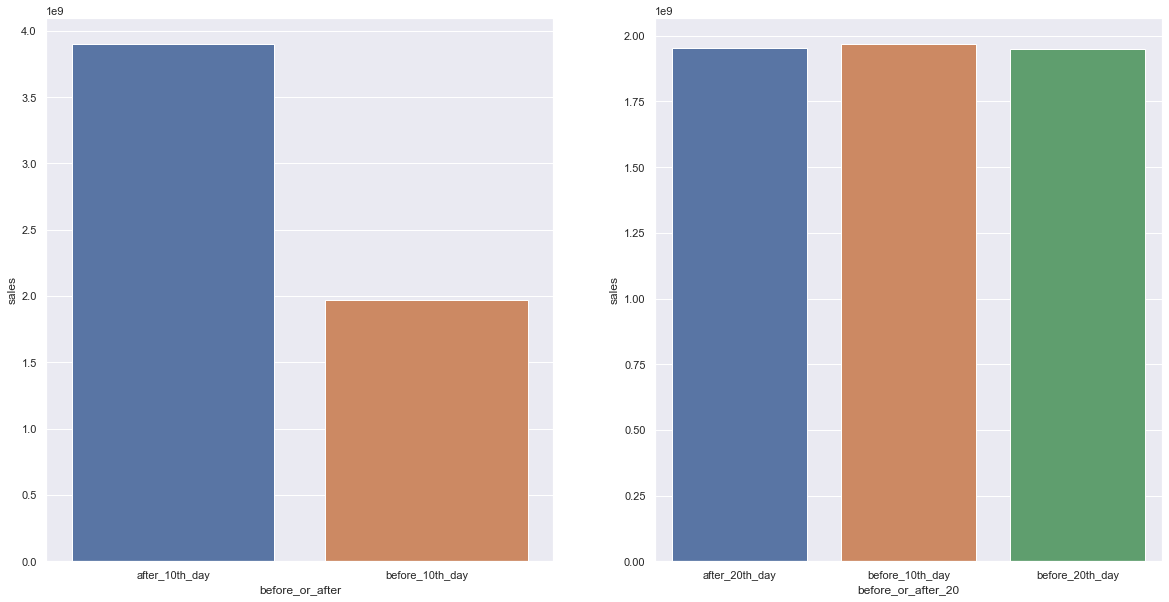

In [82]:
plt.subplot( 1, 2, 1 )
aux2 = aux1[ ['before_or_after', 'sales'] ].groupby('before_or_after').sum().reset_index()
sns.barplot( x = 'before_or_after', y = 'sales', data = aux2 );

aux1['before_or_after_20'] = aux1['day'].apply( lambda x: 'before_10th_day' if x <=10 else 
                                                   'before_20th_day' if ( (x > 10) & (x <= 20) ) else 'after_20th_day' )

aux3 = aux1[ ['before_or_after_20', 'sales'] ].groupby('before_or_after_20').sum().reset_index()

plt.subplot( 1, 2, 2 )
sns.barplot( x = 'before_or_after_20', y = 'sales', data = aux3 );

Percebe-se que, comparativamente, o volume de vendas antes do dia 10 é, comparativamente, menor em relacão a todos os outros dias após o dia 10. Isso porque, se for comparar o volume de vendas dos períodos entre os dias 1-10, 10-20 e 20-30 em um mês, o volume de vendas é muito semelhante, salvos casos em que hajam feriados estaduais, por exemplo. 

Isso, portanto, já comprova a hipótese de que as lojas deveriam sim vender mais após o dia 10 de cada mês porque o período é bem menor comparado com o resto do mês.

**Conclusão**

Hipótese "lojas deveriam vender mais depois do dia 10 de cada mês  -> **VERDADEIRA**

### 4.2.11. H11 - Lojas deveriam vender menos aos finais de semana.

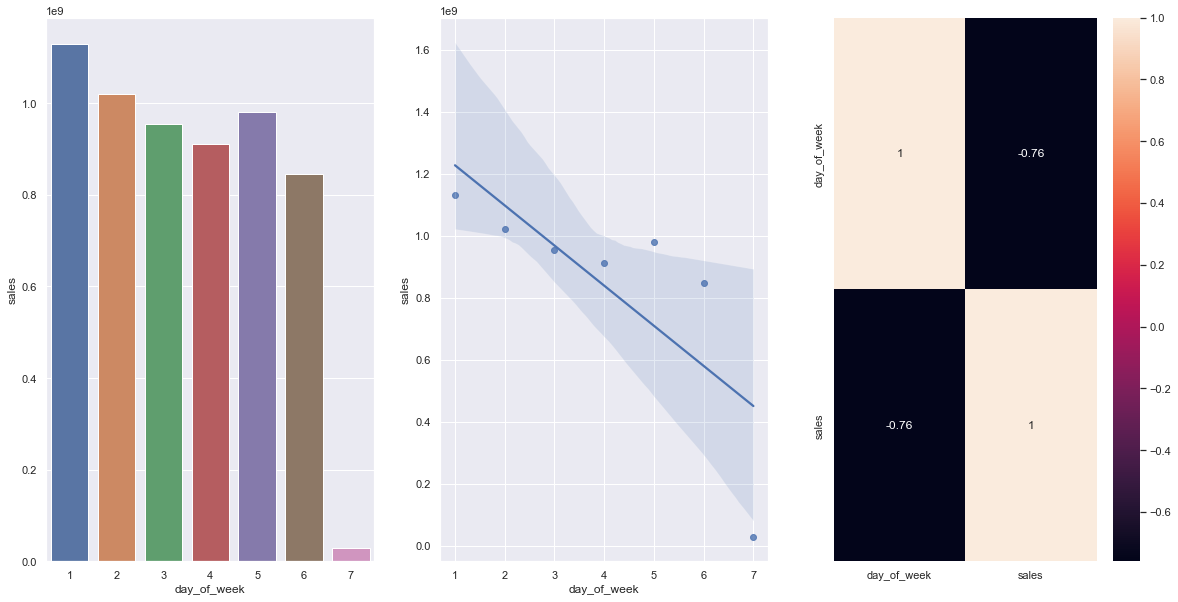

In [83]:
aux1 = df4[ ['day_of_week', 'sales'] ].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

**Conclusão**

Hipótese "lojas deveriam vender menos aos finais de semana" -> **VERDADEIRA**

### 4.2.12. H12 - Lojas deveriam vender menos durante os feriados  escolares.

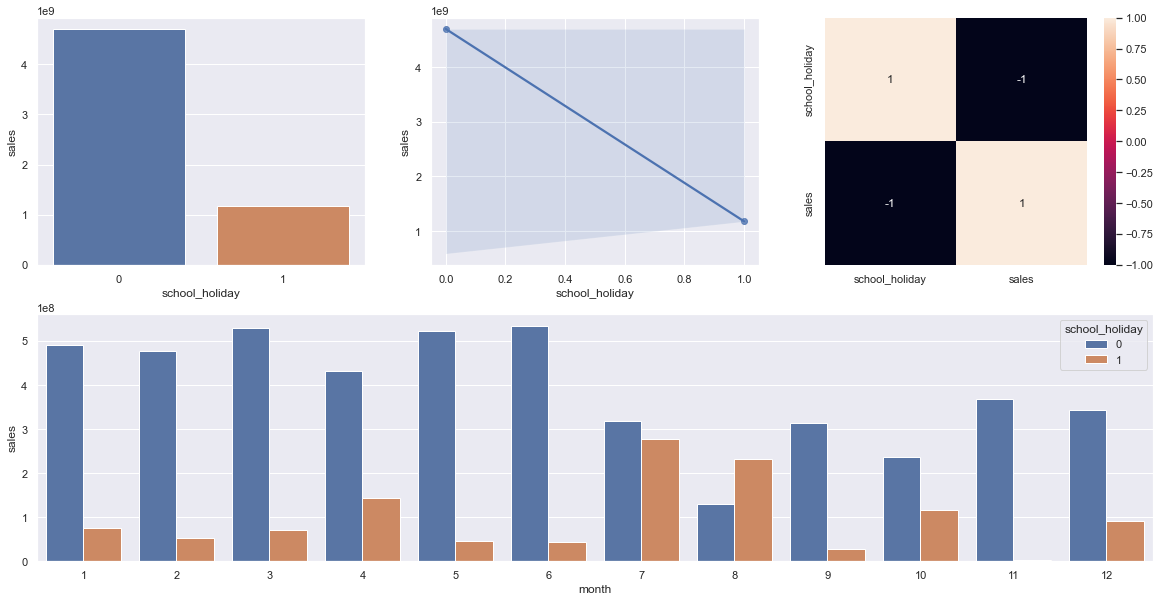

In [84]:
aux1 = df4[ ['school_holiday', 'sales'] ].groupby('school_holiday').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1 );

plt.subplot( grid[0, 1] )
sns.regplot( x = 'school_holiday', y = 'sales', data = aux1 );

plt.subplot( grid[0, 2] )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

plt.subplot( grid[1, :] )
aux2 = df4[ ['school_holiday', 'month', 'sales'] ].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2 );

À partir da análise dos 3 primeiros gráficos acima, é possível perceber que o volume de vendas em dias que são feriados escolares é muito menor, comparado com o número de vendas em dias que não são feriados escolares, porém ainda existe um volume grande de vendas nesse período específico.

Analisando se existe algum dia de feriado em que o volume de vendas pode se equiparar, e isso pode-se perceber no mês 07 do gráfico inferior: No mês de julho, as vendas dos dias de feriado escolar se equiparam com as vendas em dias que não são feriados. Isso se deve ao fato de que o mês de julho é considerado, no Hemisfério Norte, Inverno e, portanto, não há aulas. 

Portanto, a falta de aula pode induzir os alunos ou pais de alunos a investirem mais na compra de materiais escolares, ou então a realizar compras e aproveitar promocões entre pais e filhos.

**Conclusão**

Hipótese "lojas com promocões ativas por mais tempo deveriam vender mais" -> **FALSA**

Conclusão: Lojas com promocões ativas por mais tempo, i.e. com promocões consecutivas, vendem menos, comparativamente.

**Aplicacão da variável ao modelo:** Com certeza existe uma relevância da variável relacionada com os feriados escolares com relacão ao volume de vendas distribuídos mensalmente, pois apesar de haver um comportamento linear praticamente o ano todo, existem algumas flutuacões, principalmente em períodos próximos do mês 7 e 8, considerados como meses de feriado escolar.

### 4.2.13. Resumo das Hipóteses

In [ ]:
from tabulate import tabulate

In [85]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '---', '----'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Baixa'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
      ]
      
print( tabulate( tab, headers = 'firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           ---          ----
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Baixa
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

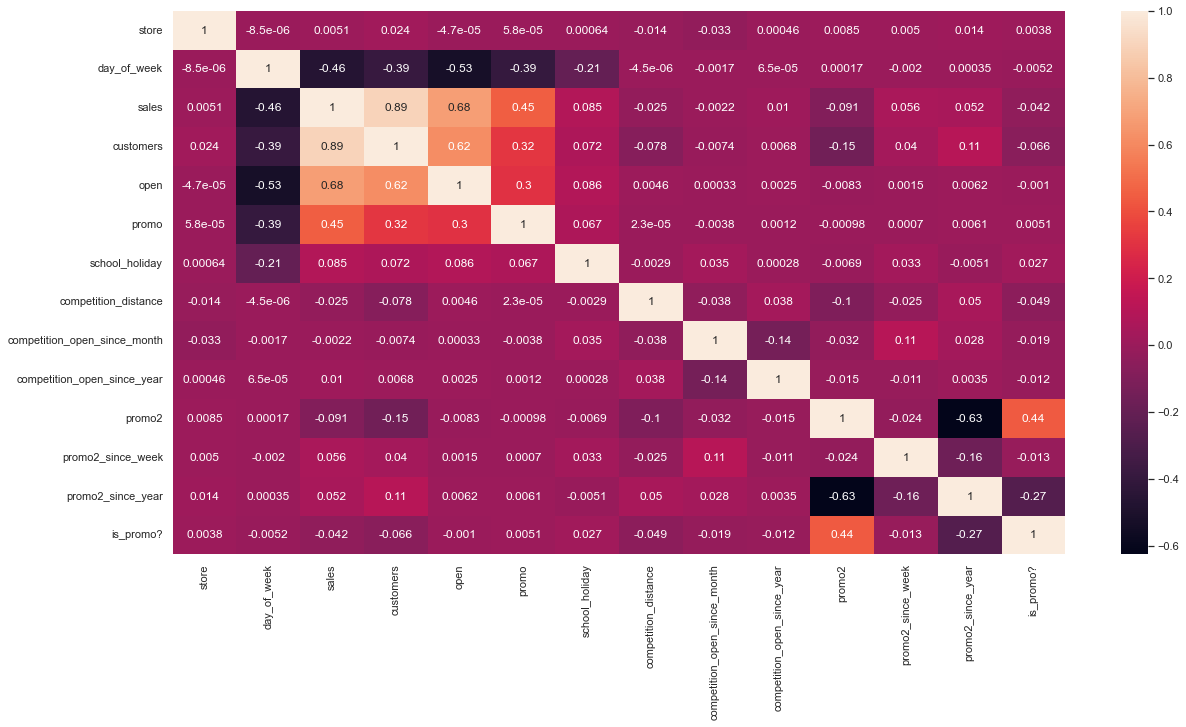

In [303]:
num_correlation = num_attributes.corr( method = 'pearson' )

sns.heatmap( num_correlation, annot = True );

### 4.3.2. Categorical Attributes

Para a análise de duas variáveis numéricas, é comum ser utilizado o método de Pearson na análise da forca de correlacão, uma vez que tal análise retorna um coeficiente o qual é o resultado da relacão estatística entre duas variáveis **contínuas e numéricas**. Isso significa que se tal relacão entre as duas variáveis não for linear, o coeficiente de correlacão de Pearson retorna um valor negativo ou baixo.

In [325]:
str_tab = df4.select_dtypes( include = 'object' )

In [326]:
str_tab.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### 4.3.2.1. O método estatístico de Cramer's V 

Para a **análise da correlacão entre duas ou mais variáveis categóricas** (e.g. 'store_type', 'assortment' e 'state_holiday'), outro método estatístico é utilizado: <u> O método de Cramer V </u>.

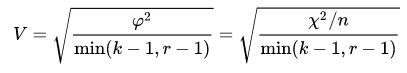

In [306]:
Image('Images/Cramer_V.png')

Inicialmente, calcula-se a "Confusion Matrix":

In [327]:
cm = pd.crosstab( str_tab['state_holiday'], str_tab['store_type'] ).values

cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

A partir da "confusion matrix" acima, pode-se perceber que e.g. 4 grupos de lojas do tipo 'a' participaram do feriado estadual 'Christimas'. Isso é possível de ser confirmado a partir da tabela abaixo, aplicadas as seguintes condicões:

In [328]:
str_tab[ ( str_tab['state_holiday'] == 'Christimas' ) & ( str_tab['store_type'] == 'a' ) ]

,state_holiday,store_type,assortment,year_week
241499,Christimas,a,extended,2014-51
241977,Christimas,a,extended,2014-51
616339,Christimas,a,extended,2013-51
616908,Christimas,a,extended,2013-51


Definicão da variável Chi2, o qual deriva do teste de Chi quadrado de Pearson:

In [309]:
chi2 = ss.chi2_contingency(cm)[0]

O teste de Chi2 retornou: (1) O valor do teste de Chi2, (2) O P-valor, (3) O número de graus de liberdade da análise, (4) A tabela ou matriz de frequência.

Porém, o que interessa, na verdade, é o valor do teste.

In [310]:
chi2

12792.159524019908

A variável "n" representa a soma total de todas as observacões, sendo essas observacões como o total de possibilidades para o mínimo das linhas (r) e colunas (k):

In [311]:
n = cm.sum()

r, k = cm.shape

Por fim, aplica-se o resultado das variáveis na fórmula do método:

In [312]:
v = np.sqrt( ( chi2/n )/( min(  k-1, r-1 ) ) )

v

0.07106457093267678

Lembrete: No caso da análise de correlacão a partir do método de Cramer's V, ao contrário do método de correlacão de Pearson, o coeficiente de Cramer's V possui um range de 0-1, não possuindo uma correlacão negativa. Isso se deve ao fato deste último tratar apenas de variáveis categóricas, ao contrário do primeiro, que trata de variáveis numéricas (Mais próximo de 0: Menor a correlacão; mais próximo de 1: Maior a correlacão).

#### 4.3.2.2. A aplicacão de Cramer's V na análise das variáveis categóricas

A fim de automatizar a aplicacão do método em todo o dataframe, utiliza-se da funcão ('cramer_v') introduzida na secão "0.1. Helper Functions" a fim de automatizar a equacão para aplicacão do método.

A correlacão entre as variáveis 'state_holiday' e 'store_type' é dada como sendo:

In [343]:
cramer_v( str_tab['state_holiday'], str_tab['store_type'] )

0.07106457093267678

A correlacão entre as variáveis 'state_holiday' e 'assortment' é dada como sendo:

In [330]:
cramer_v( str_tab['state_holiday'], str_tab['assortment'] )

0.06754556782088658

A correlacão entre as variáveis 'store_type' e 'assortment' é dada como sendo: 

In [344]:
cramer_v( str_tab['store_type'], str_tab['assortment'] )

0.5384563240972372

#### 4.3.2.3. Corrigindo o viés do método de Cramer's V

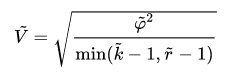

In [318]:
Image( 'Images/Cramer_V_Corrected.png' )

Ao se aplicar a análise multivariada em atributos categóricos utilizando-se do Método de Cramer's V, a tendência é que este método sempre tenda a superestimar a forca da correlacão, ou associacão entre os atributos categóricos analisados. 

Dessa forma, é necessário realizar a correcão desse viés, a qual é feita utilizando-se da funcão 'cramer_v_corr', previamente introduzida na secão "0.1. Helper Functions".

A fim de se construir a matriz com todas as combinacões possíveis das correlacões das variáveis categóricas, aplica-se a funcão de Cramer's V corrigida e constrói o DataFrame associado:

In [345]:
# Forcar a utilizar somente variáveis categóricas:
str_tab = df4.select_dtypes( include = 'object' )

# Aplicar as condicões para construcão do dataframe:
cramer1 = cramer_v_corr( str_tab['state_holiday'], str_tab['state_holiday'] )
cramer2 = cramer_v_corr( str_tab['state_holiday'], str_tab['store_type'] )
cramer3 = cramer_v_corr( str_tab['state_holiday'], str_tab['assortment'] )

cramer4 = cramer_v_corr( str_tab['store_type'], str_tab['state_holiday'] )
cramer5 = cramer_v_corr( str_tab['store_type'], str_tab['store_type'] )
cramer6 = cramer_v_corr( str_tab['store_type'], str_tab['assortment'] )

cramer7 = cramer_v_corr( str_tab['assortment'], str_tab['state_holiday'] )
cramer8 = cramer_v_corr( str_tab['assortment'], str_tab['store_type'] )
cramer9 = cramer_v_corr( str_tab['assortment'], str_tab['assortment'] )

# Construir o dataframe com os valores das correcões a partir do método de Cramer's V:
cramer_df = pd.DataFrame({ 'state_holiday': [cramer1, cramer2, cramer3],
                           'store_type': [cramer4, cramer5, cramer6],
                           'assortment': [cramer7, cramer8, cramer9] })

cramer_df = cramer_df.set_index( cramer_df.columns )

cramer_df


,state_holiday,store_type,assortment
state_holiday,1.00,0.07,0.07
store_type,0.07,1.00,0.54
assortment,0.07,0.54,1.00


Após a construcão do dataframe a ser utilizado na análise multivariada dos atributos categóricos, pode-se por fim analisar o 'heatmap' correlacões:

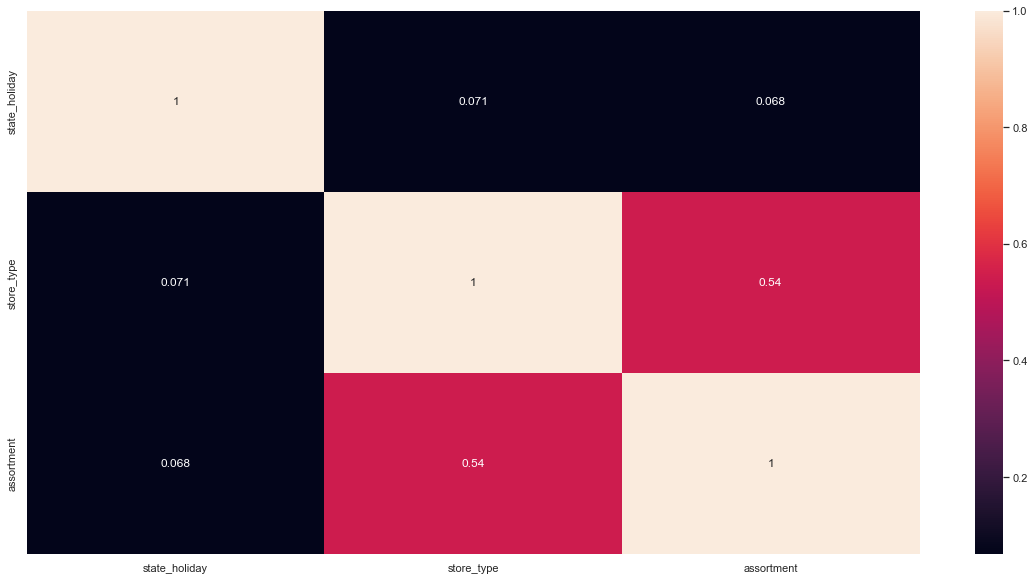

In [346]:
sns.heatmap( cramer_df, annot = True );

Análise do mapa das correlacões acima:

**1. Relacão state_holiday vs store_type:**
Correlacão = 0.071

**2. Relacão state_holiday vs assortment:**
Correlacão = 0.071

**3. Relacão store_type vs assortment:**
Correlacão = 0.54
Isso indica que ambas os atributos para as lojas são bastante correlacionáveis positivamente, o que pode ser justificado pelo fato de que, quanto maior o tamanho da loja ('store_type'), maior o sortimento dos produtos ('assortment'), ou tamanho de estoque.
